In [1]:
import json
import os
import sys
from pathlib import Path

import dabest
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import numpy as np
import pandas as pd
import yaml

from mne.time_frequency import AverageTFR, EpochsTFR, tfr_morlet, tfr_multitaper
from mne_bids import BIDSPath
from mne_bids.read import read_raw_bids
from mne_bids.tsv_handler import _from_tsv
from ptitprince import PtitPrince as pt
from rerf.rerfClassifier import rerfClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    auc, 
    accuracy_score, 
    cohen_kappa_score, 
    make_scorer, 
    plot_confusion_matrix, 
    roc_auc_score, 
    roc_curve
)
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer, label_binarize
from sklearn.utils import check_random_state
from tqdm import tqdm

if str(Path(os.path.abspath(" ")).parents[3]) not in sys.path:
    sys.path.append(str(Path(os.path.abspath(" ")).parents[3]))

from mtsmorf.move_exp.cv import fit_classifiers_cv, initialize_classifiers
from mtsmorf.move_exp.functions.move_experiment_functions import (
    get_event_data, 
    get_preprocessed_labels,
)
from mtsmorf.move_exp.functions.time_window_selection_functions import (
    bootstrap_independence_test,
    bootstrap_independence_test_OLS,
    get_event_durations, 
    plot_event_onsets,
    plot_event_durations,
    plot_durations_by_label_raincloud,
    plot_durations_by_label_kde,
    plot_durations_cv_split,
)

from mtsmorf.io.read import read_dataset, read_trial, get_trial_info, _get_anatomical_bad_chs
from mtsmorf.io.utils import NumpyEncoder
from mtsmorf.move_exp.experiments import cv_fit
from mtsmorf.move_exp.plotting import (
    plot_signals,
    plot_spectrogram,
    plot_epoch_time_series,
    plot_roc_multiclass_cv,
    plot_feature_importances,
    plot_cv_indices, 
    plot_classifier_performance,
    plot_roc_aucs,
    plot_accuracies,
)

plt.rcParams.update({
    "font.family": "sans-serif", 
    "font.size": 14
})

%load_ext autoreload
%autoreload 2
%matplotlib inline

## Set paths and experiment defaults

In [14]:
with open(Path(os.path.abspath('')).parents[3] / "motor-decoding/mtsmorf/move_exp/config.yml") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

with open(Path(os.path.abspath('')).parents[3] / "motor-decoding/mtsmorf/move_exp/metadata.yml") as f:
    metadata = yaml.load(f, Loader=yaml.FullLoader)

bids_root = Path(config["bids_root"])
derivatives_path = Path(config["derivatives_path"])
results_path = Path(config["results_path"])

print(f"bids_root: {bids_root}")
print(f"derivatives_path: {derivatives_path}")
print(f"results_path: {results_path}")

bids_root: /Users/ChesterHuynh/OneDrive - Johns Hopkins/efri
derivatives_path: /Users/ChesterHuynh/OneDrive - Johns Hopkins/efri/derivatives
results_path: /Users/ChesterHuynh/OneDrive - Johns Hopkins/efri/derivatives/mtmorf


In [91]:
rng = 1
resample_rate = 500
n_splits = 5
cv = StratifiedKFold(n_splits)

# Showing AUROC Scores

## Time Domain (03-25-21)

In [269]:
import json
subjects = metadata["subjects"]

subject_clf_scores = {}
clf_names = ["MT-MORF", "S-RerF", "RandomForestClassifier", "LogisticRegression"]
new_names = ["MT-MORF", "SPORF", "RF", "Log. Reg"]
for subject in subjects:
    subject_clf_scores[subject] = {}
    for clf_name, new_name in zip(clf_names, new_names):
        with open(
            results_path 
            / f"decode_directionality/{subject}/tmin=-0.2_tmax=0.5/time_domain/{subject}_{clf_name}_results.json", "r"
        ) as f:
            subject_clf_scores[subject][new_name] = json.load(f)

auroc_df = []
for subject, clf_scores in subject_clf_scores.items():
    for clf_name, scores in clf_scores.items():
        auroc_df.append([subject, clf_name, scores["test_roc_auc_ovr"]])
auroc_df = pd.DataFrame(auroc_df, columns=["Subject", "Classifier Name", "ROC AUC OvR"])
auroc_df = pd.DataFrame({"Subject": np.repeat(auroc_df["Subject"].values, auroc_df["ROC AUC OvR"].str.len()),
                         "Classifier Name": np.repeat(auroc_df["Classifier Name"].values, auroc_df["ROC AUC OvR"].str.len()),
                         'ROC AUC OvR':np.concatenate(auroc_df["ROC AUC OvR"].values)})

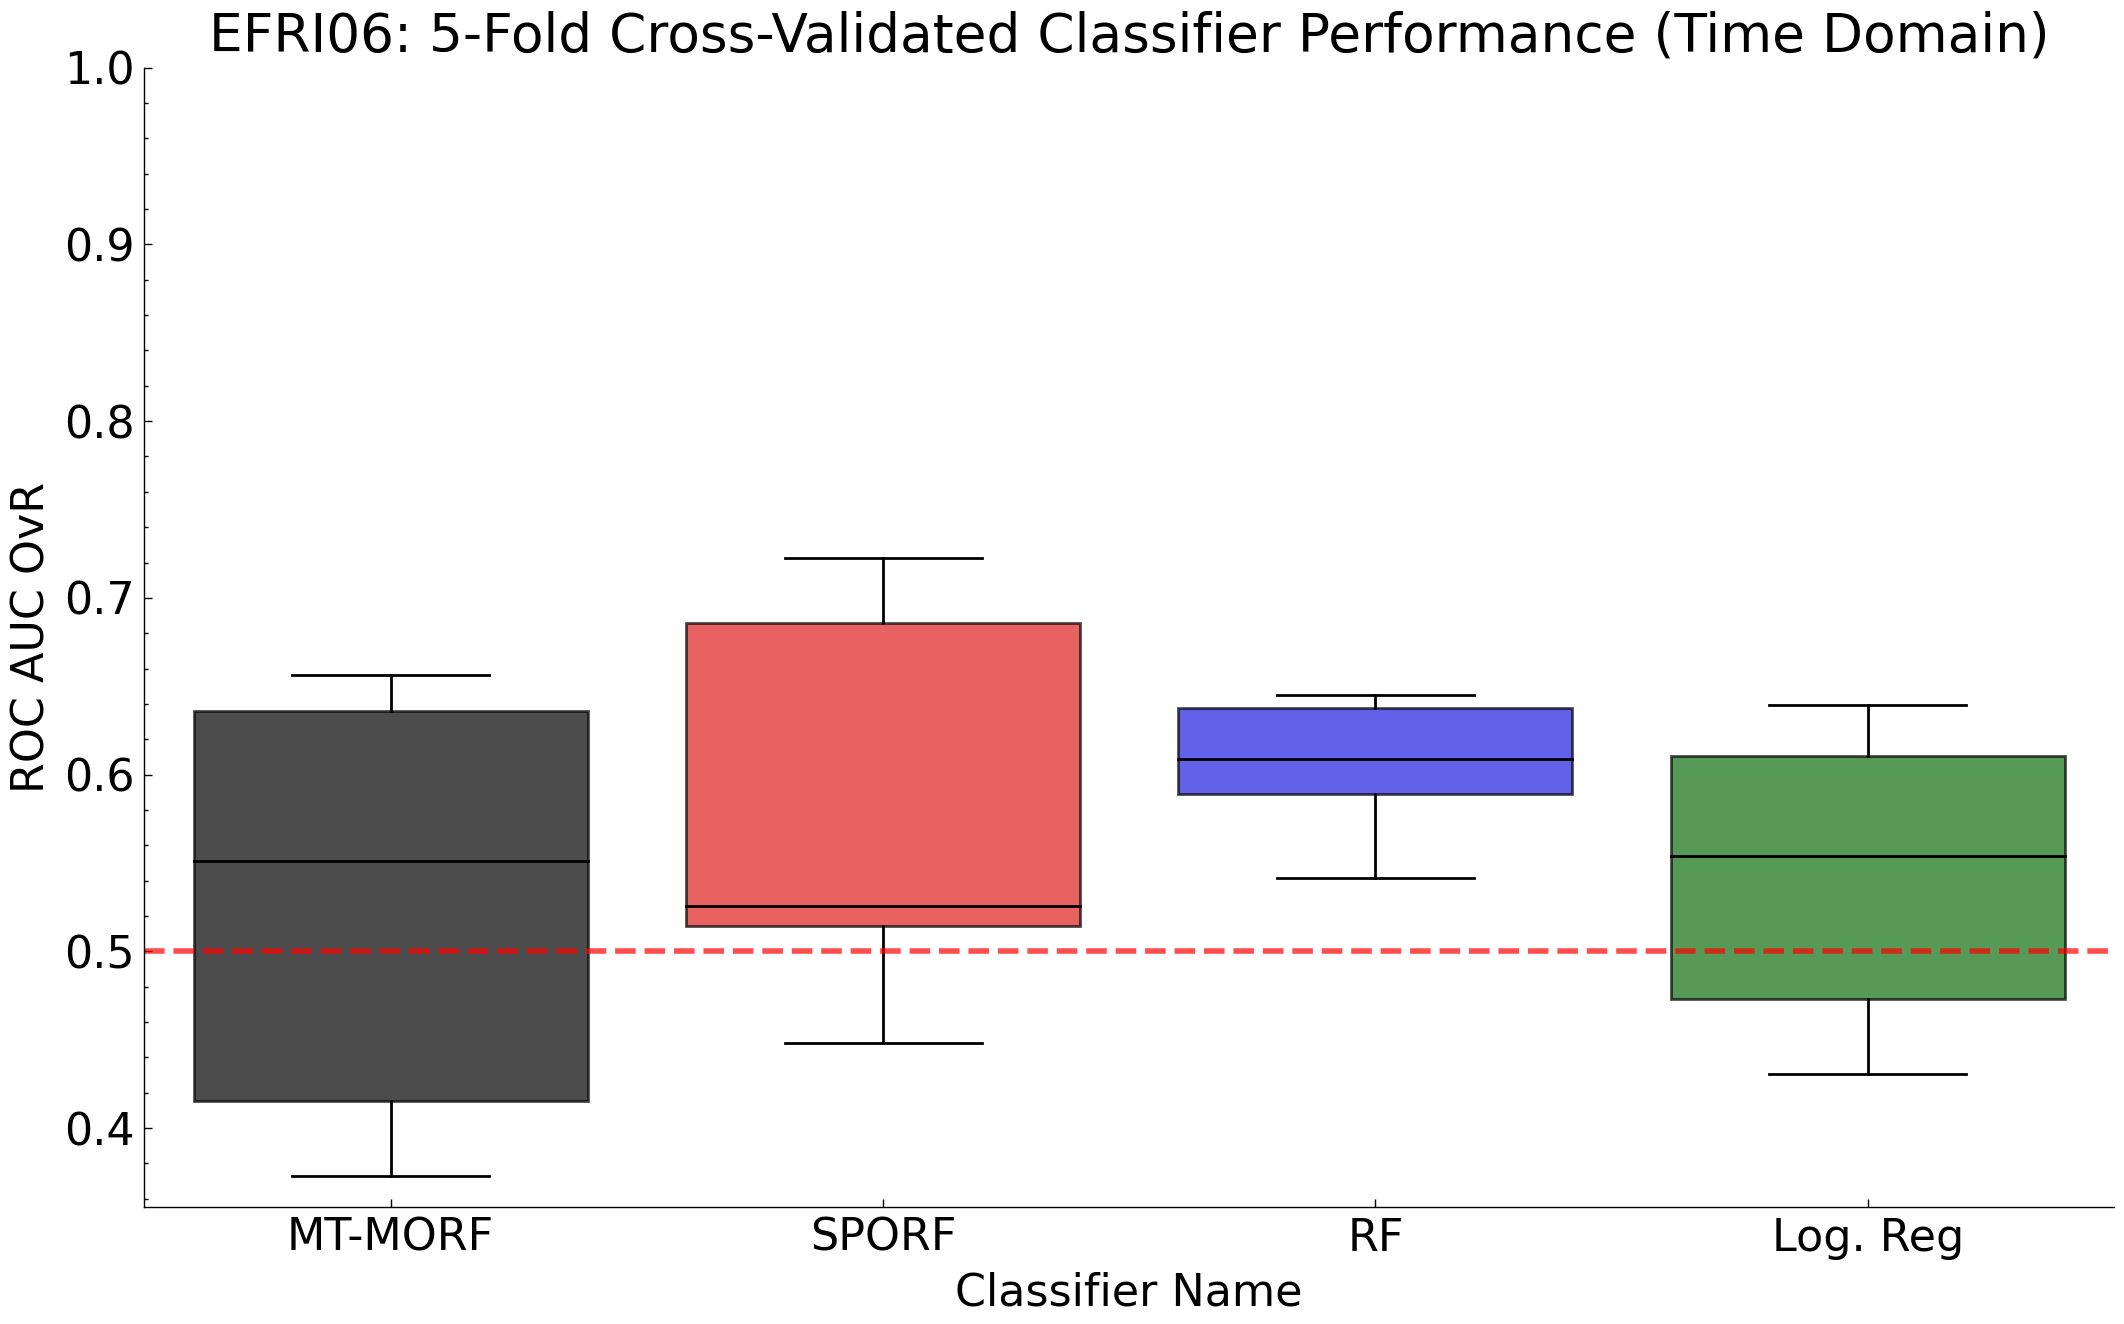

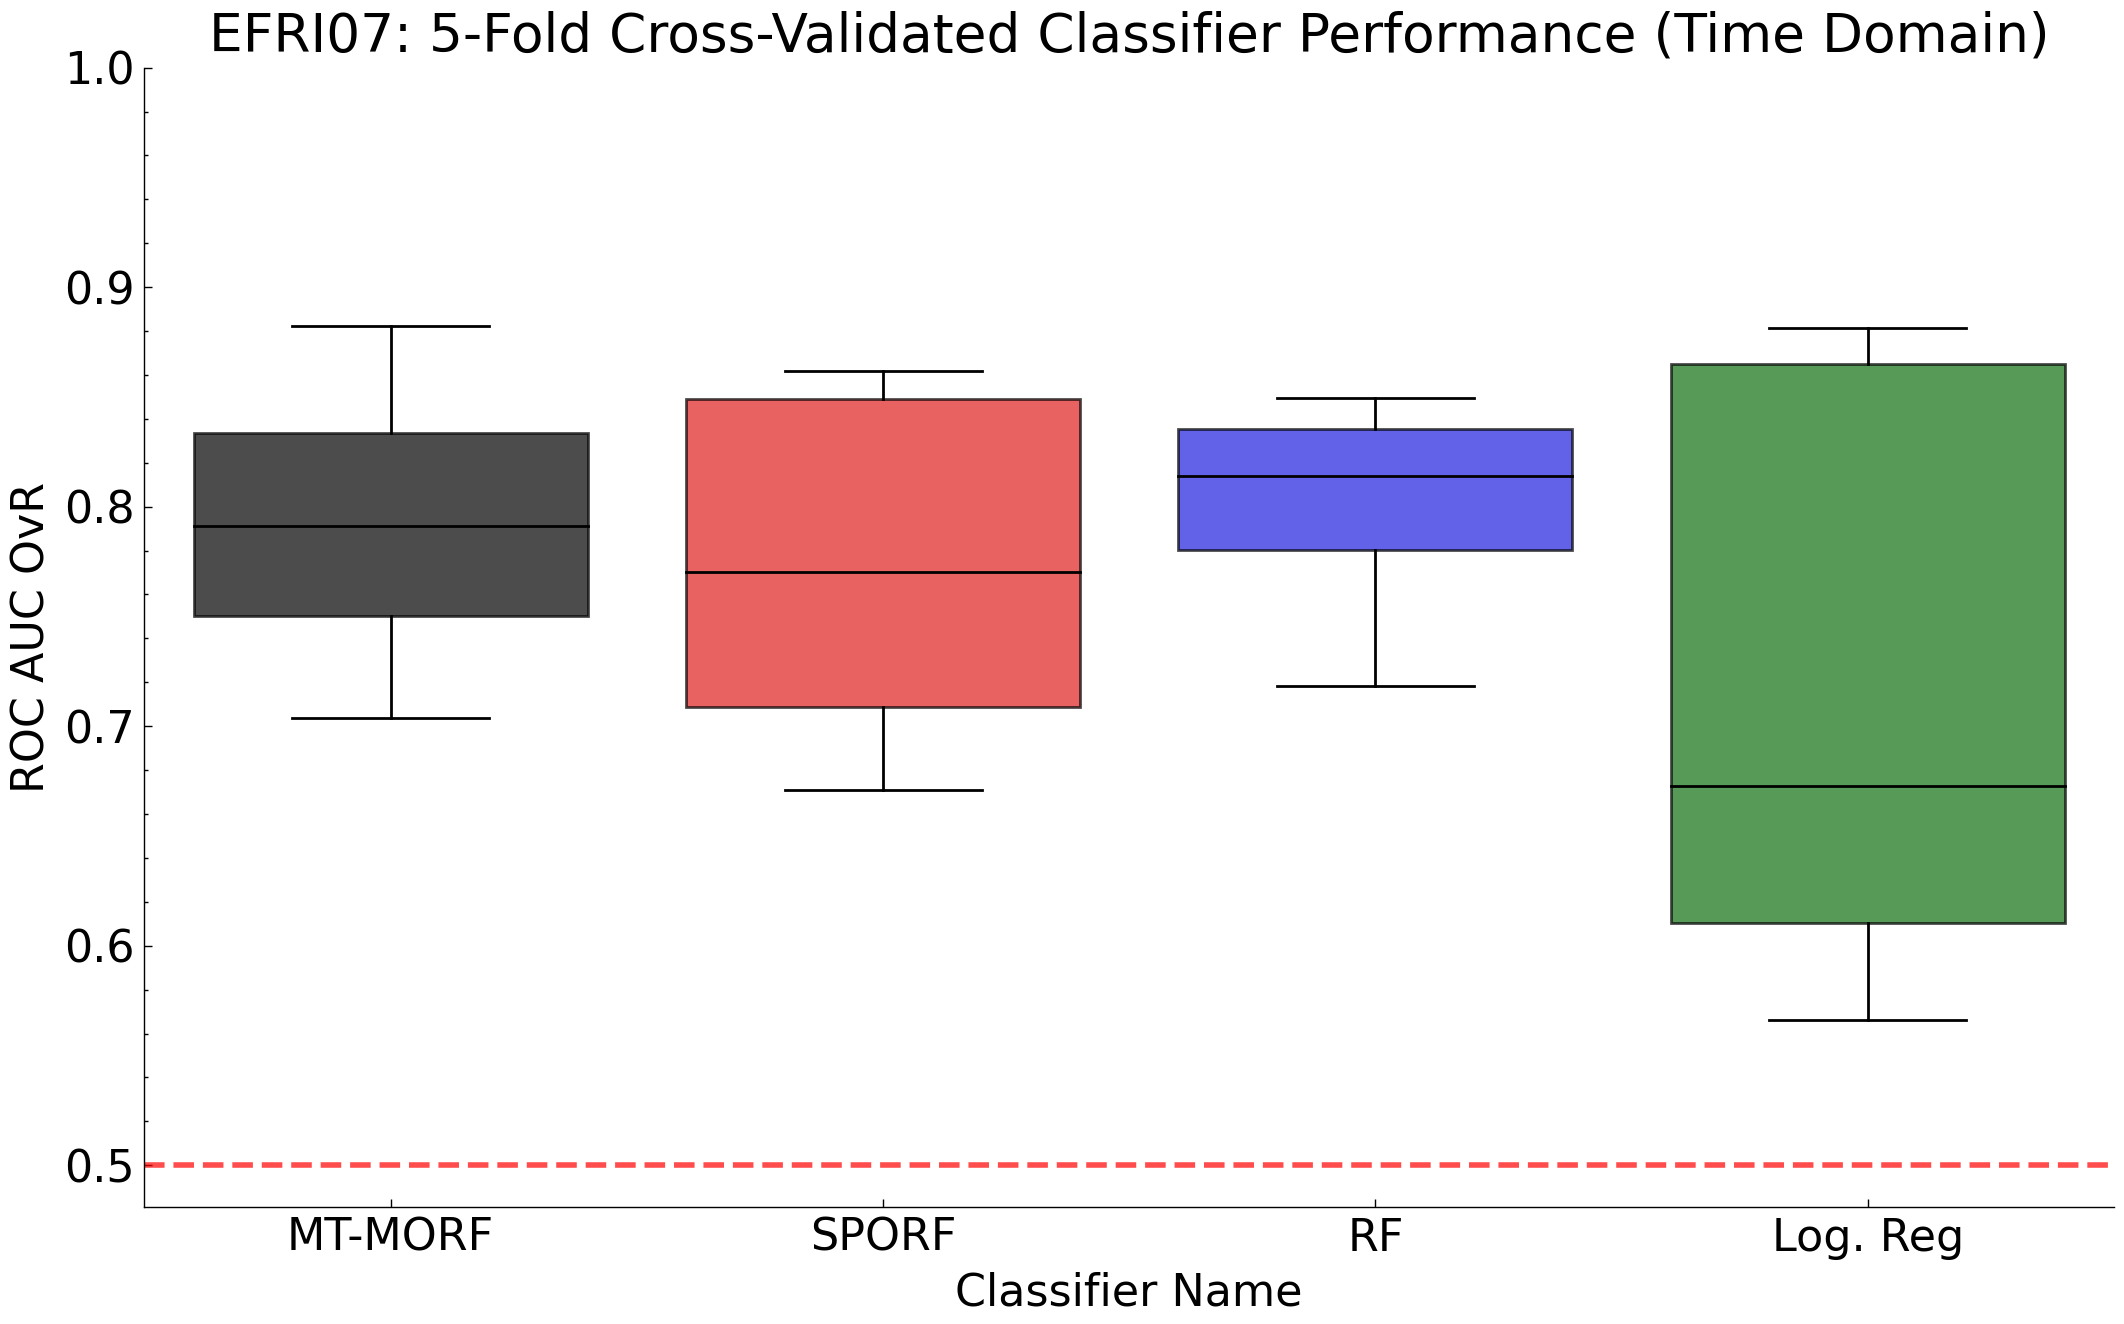

In [270]:
selected_subjects = ["efri06", "efri07"]
for subject in selected_subjects:
    df = auroc_df[auroc_df.Subject == subject]
    plt.rcParams.update({"font.size": 16})
    fig, ax = plt.subplots(figsize=(11, 7), dpi=200)
    sns.boxplot(x="Classifier Name", y="ROC AUC OvR", data=df, dodge=True, boxprops=dict(alpha=0.7), ax=ax)
    ax.axhline(0.5, label="Chance", ls="--", lw=2, c='r', alpha=0.7)
    ax.set_title(f"{subject.upper()}: {n_splits}-Fold Cross-Validated Classifier Performance (Time Domain)")
    ax.set_ylim(None, 1)
    
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.tick_params(axis='x', which='minor', bottom=False)
    fig.tight_layout()
    plt.show()

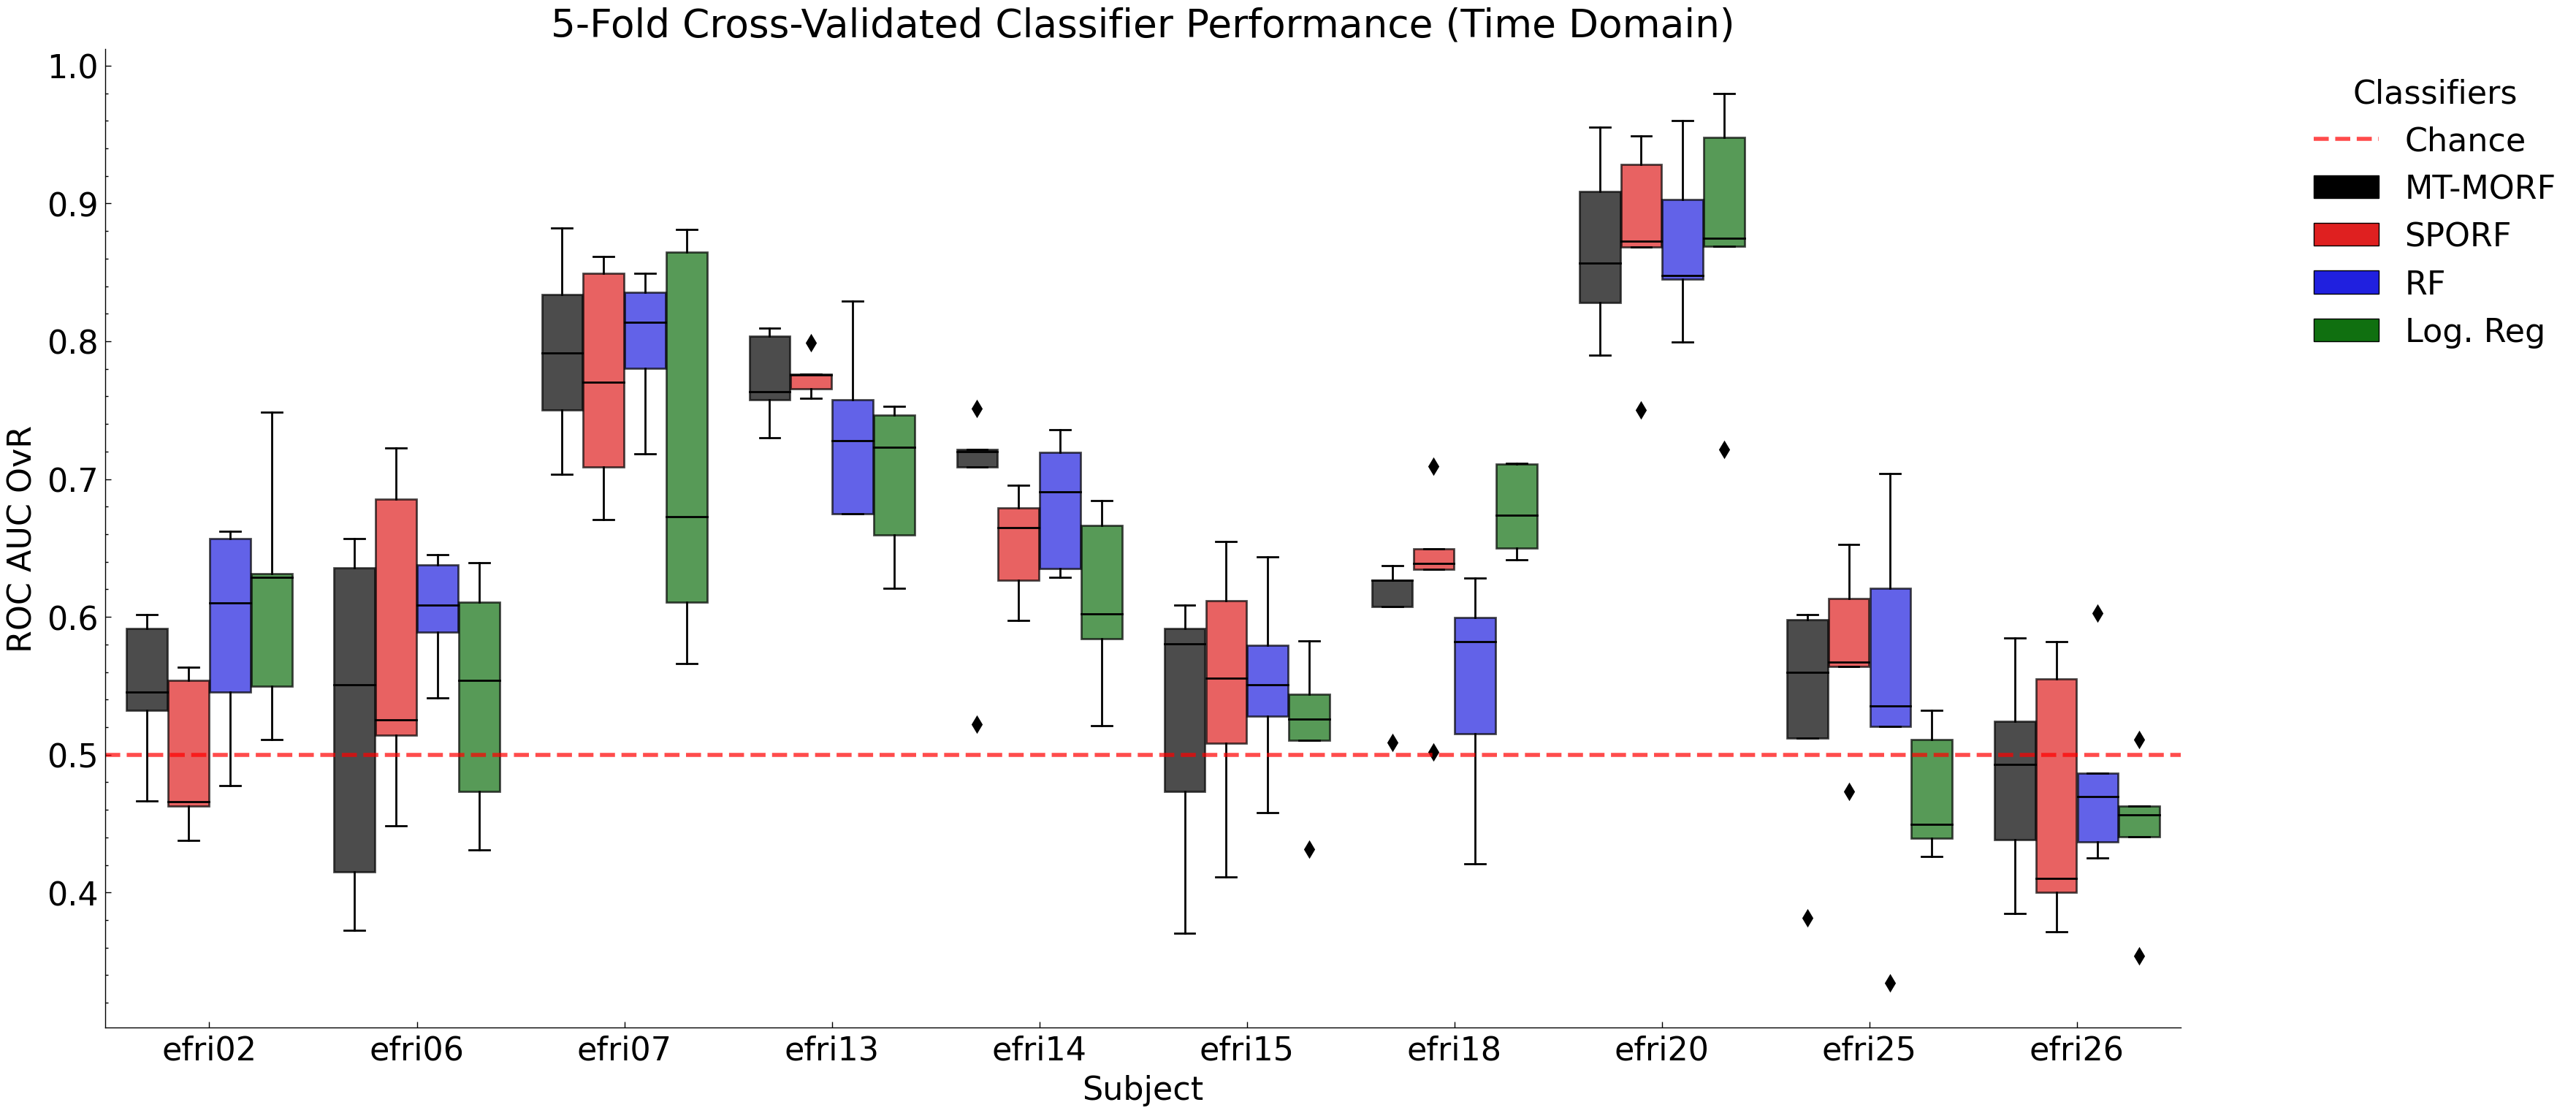

In [271]:
plt.rcParams.update({"font.size": 16})
fig, ax = plt.subplots(figsize=(18, 8), dpi=200)
sns.boxplot(x="Subject", y="ROC AUC OvR", hue="Classifier Name", data=auroc_df, dodge=True, boxprops=dict(alpha=0.7), ax=ax)
ax.axhline(0.5, label="Chance", ls="--", lw=2, c='r', alpha=0.7)
ax.set_title(f"{n_splits}-Fold Cross-Validated Classifier Performance (Time Domain)")
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(axis='x', which='minor', bottom=False)
ax.legend(title='Classifiers', bbox_to_anchor=(1.05, 1), loc='upper left')
fig.tight_layout();

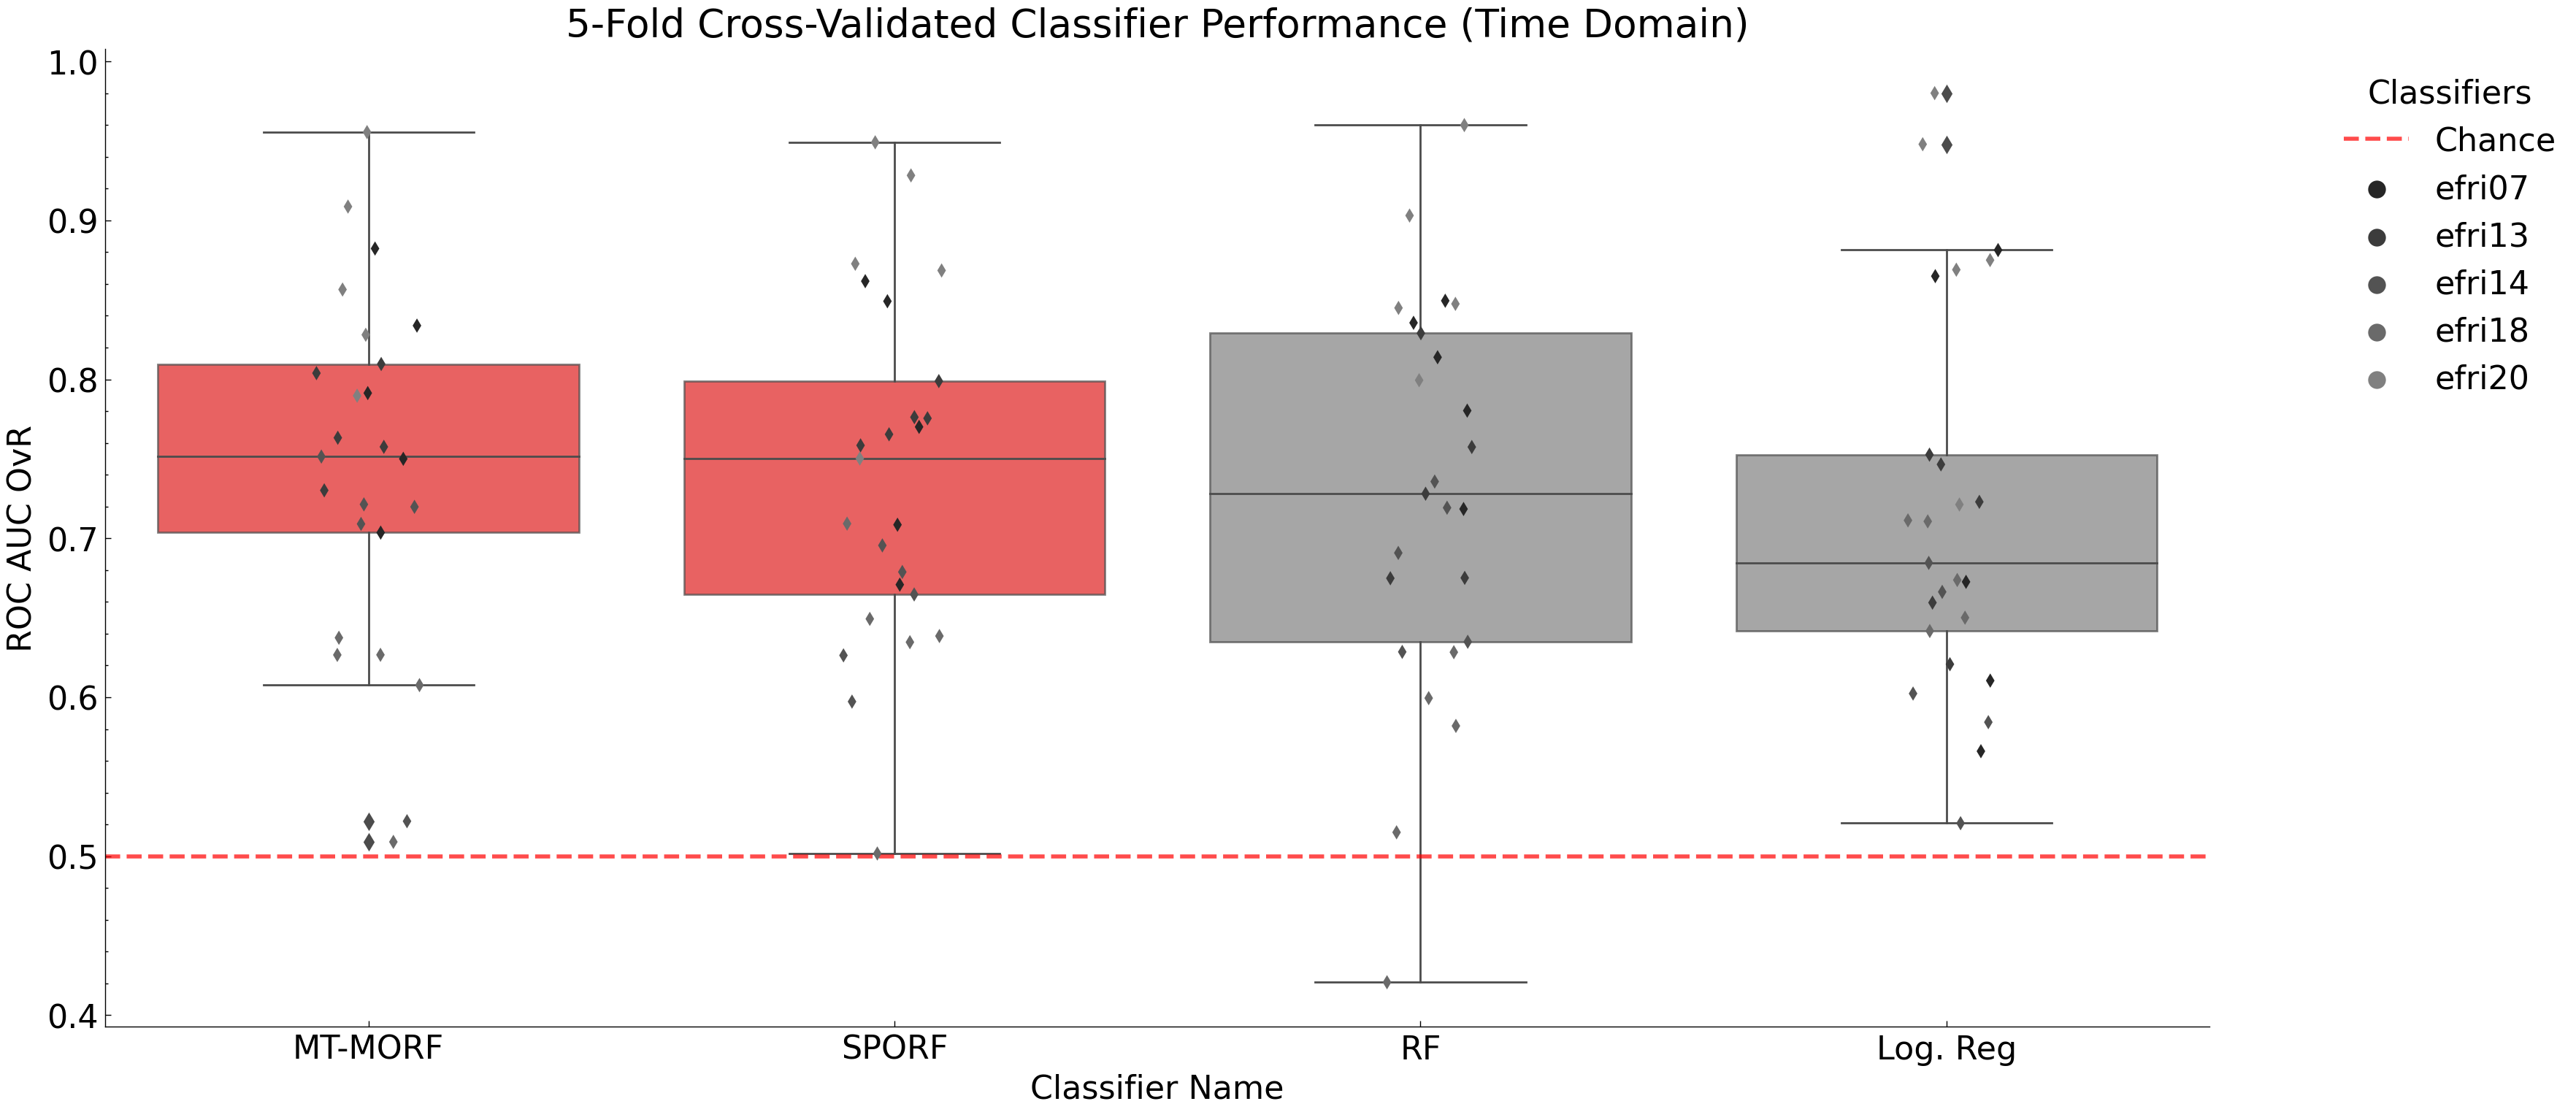

In [278]:
selected_auroc_df = auroc_df[auroc_df.Subject.isin(["efri07", "efri13", "efri14", "efri18", "efri20"])]
plt.rcParams.update({"font.size": 16})
fig, ax = plt.subplots(figsize=(18, 8), dpi=200)
sns.stripplot(x="Classifier Name", y="ROC AUC OvR", hue="Subject", marker='d', data=selected_auroc_df, dodge=False, ax=ax, color="gray")
palette = {"MT-MORF": "r", "SPORF": "r", "RF": "gray", "Log. Reg": "gray"}
sns.boxplot(x="Classifier Name", y="ROC AUC OvR", data=selected_auroc_df, dodge=False, boxprops=dict(alpha=0.7), ax=ax, palette=palette)
ax.axhline(0.5, label="Chance", ls="--", lw=2, c='r', alpha=0.7)
ax.set_title(f"{n_splits}-Fold Cross-Validated Classifier Performance (Time Domain)")
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(axis='x', which='minor', bottom=False)
ax.legend(title='Classifiers', bbox_to_anchor=(1.05, 1), loc='upper left')
fig.tight_layout();

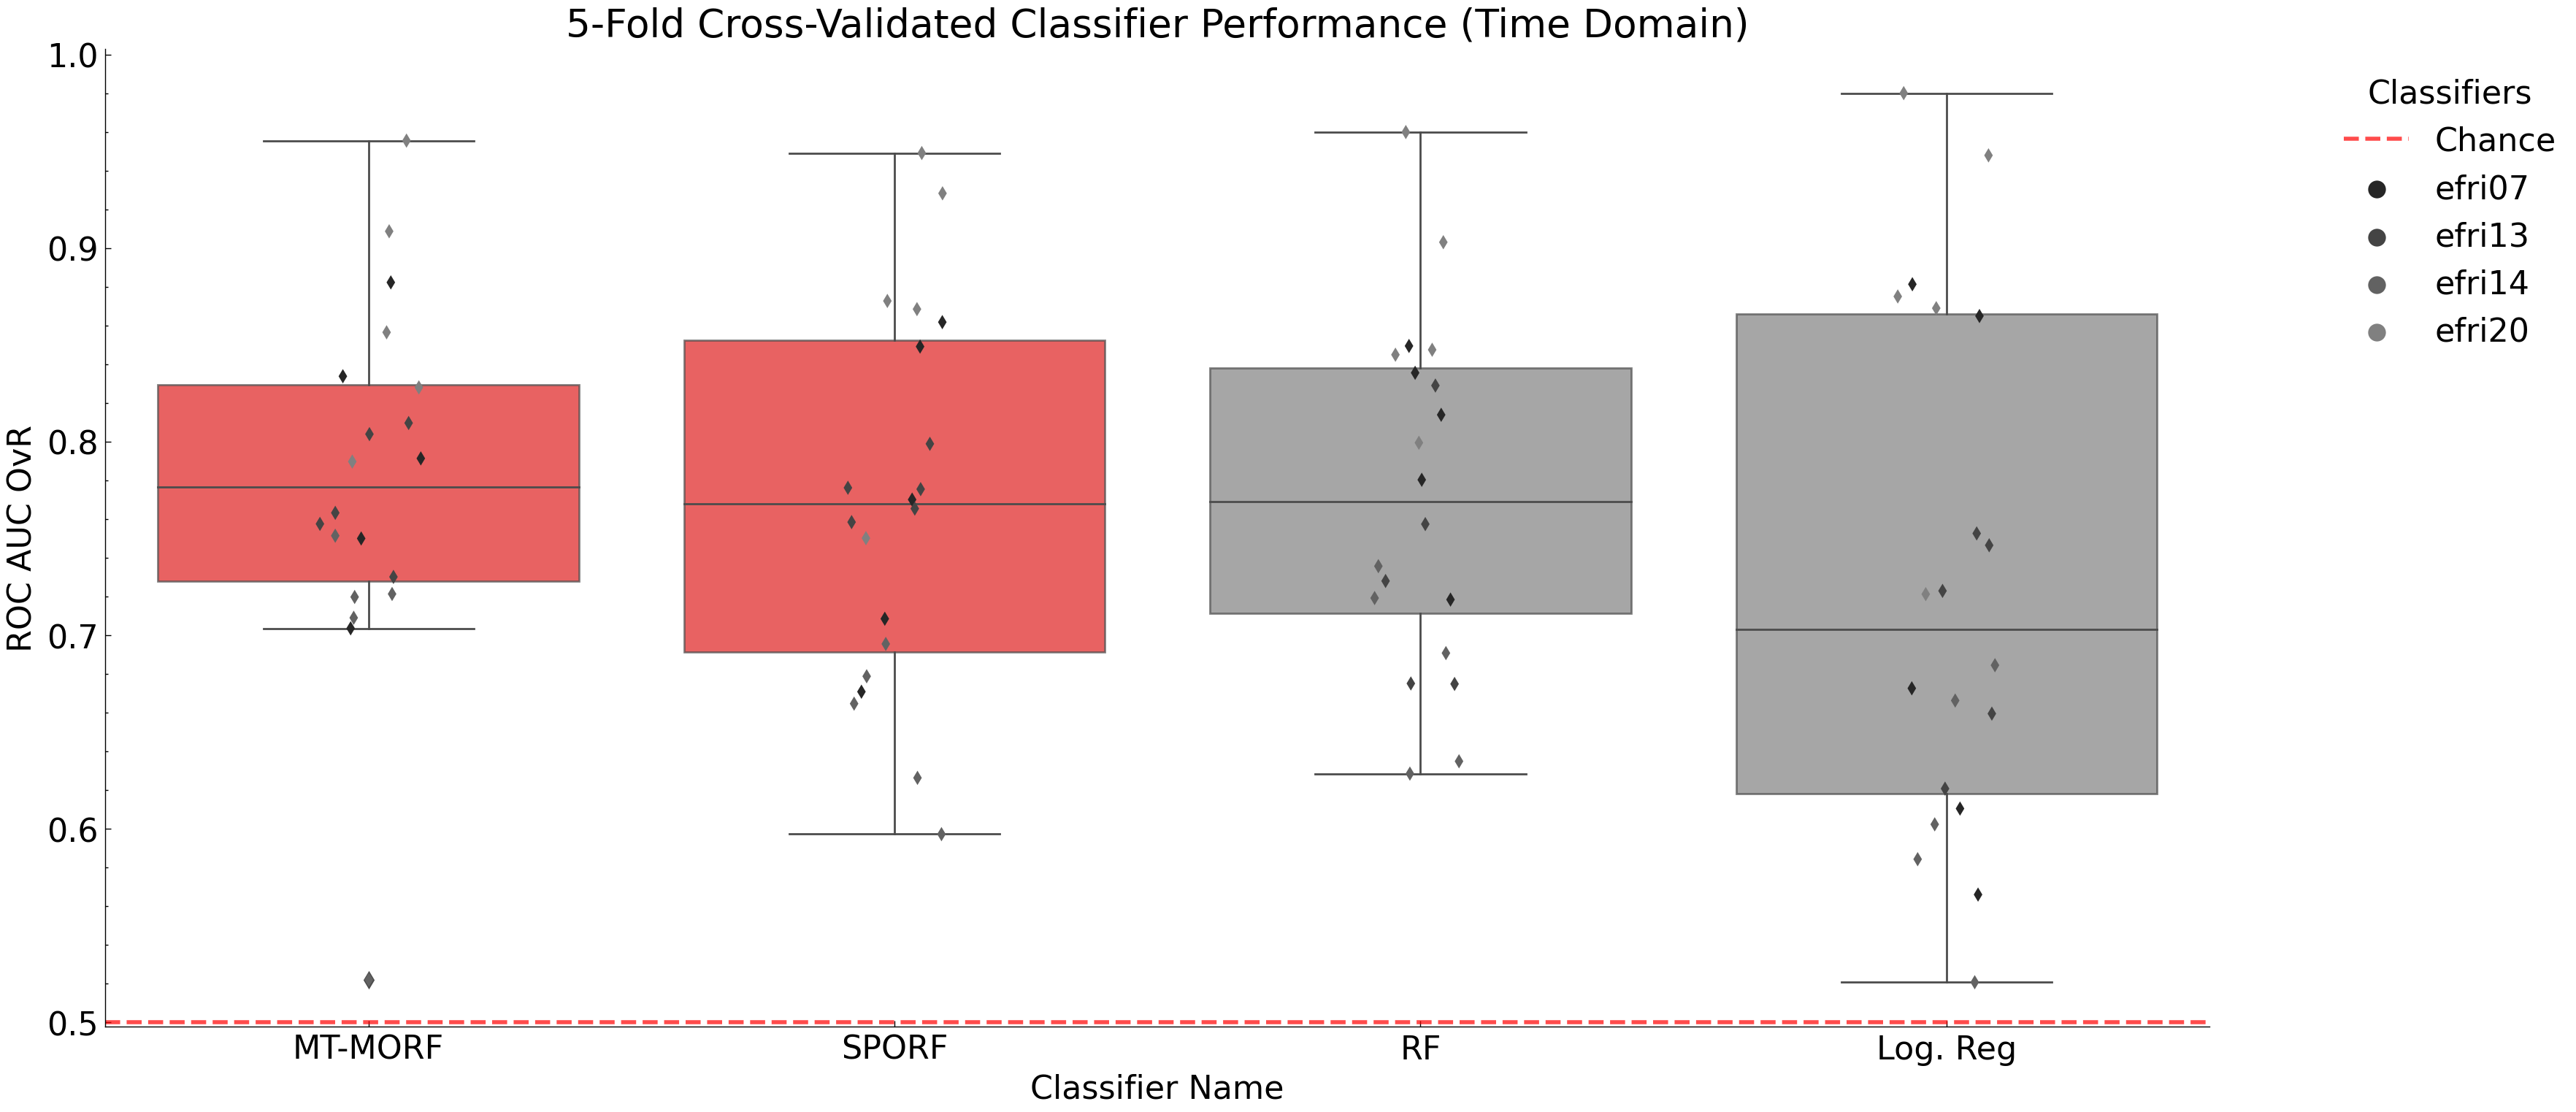

In [276]:
selected_auroc_df = auroc_df[auroc_df.Subject.isin(["efri07", "efri13", "efri14", "efri20"])]
plt.rcParams.update({"font.size": 16})
fig, ax = plt.subplots(figsize=(18, 8), dpi=200)
sns.stripplot(x="Classifier Name", y="ROC AUC OvR", hue="Subject", marker='d', data=selected_auroc_df, dodge=False, ax=ax, color="gray")
palette = {"MT-MORF": "r", "SPORF": "r", "RF": "gray", "Log. Reg": "gray"}
sns.boxplot(x="Classifier Name", y="ROC AUC OvR", data=selected_auroc_df, dodge=False, boxprops=dict(alpha=0.7), ax=ax, palette=palette)
ax.axhline(0.5, label="Chance", ls="--", lw=2, c='r', alpha=0.7)
ax.set_title(f"{n_splits}-Fold Cross-Validated Classifier Performance (Time Domain)")
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(axis='x', which='minor', bottom=False)
ax.legend(title='Classifiers', bbox_to_anchor=(1.05, 1), loc='upper left')
fig.tight_layout();

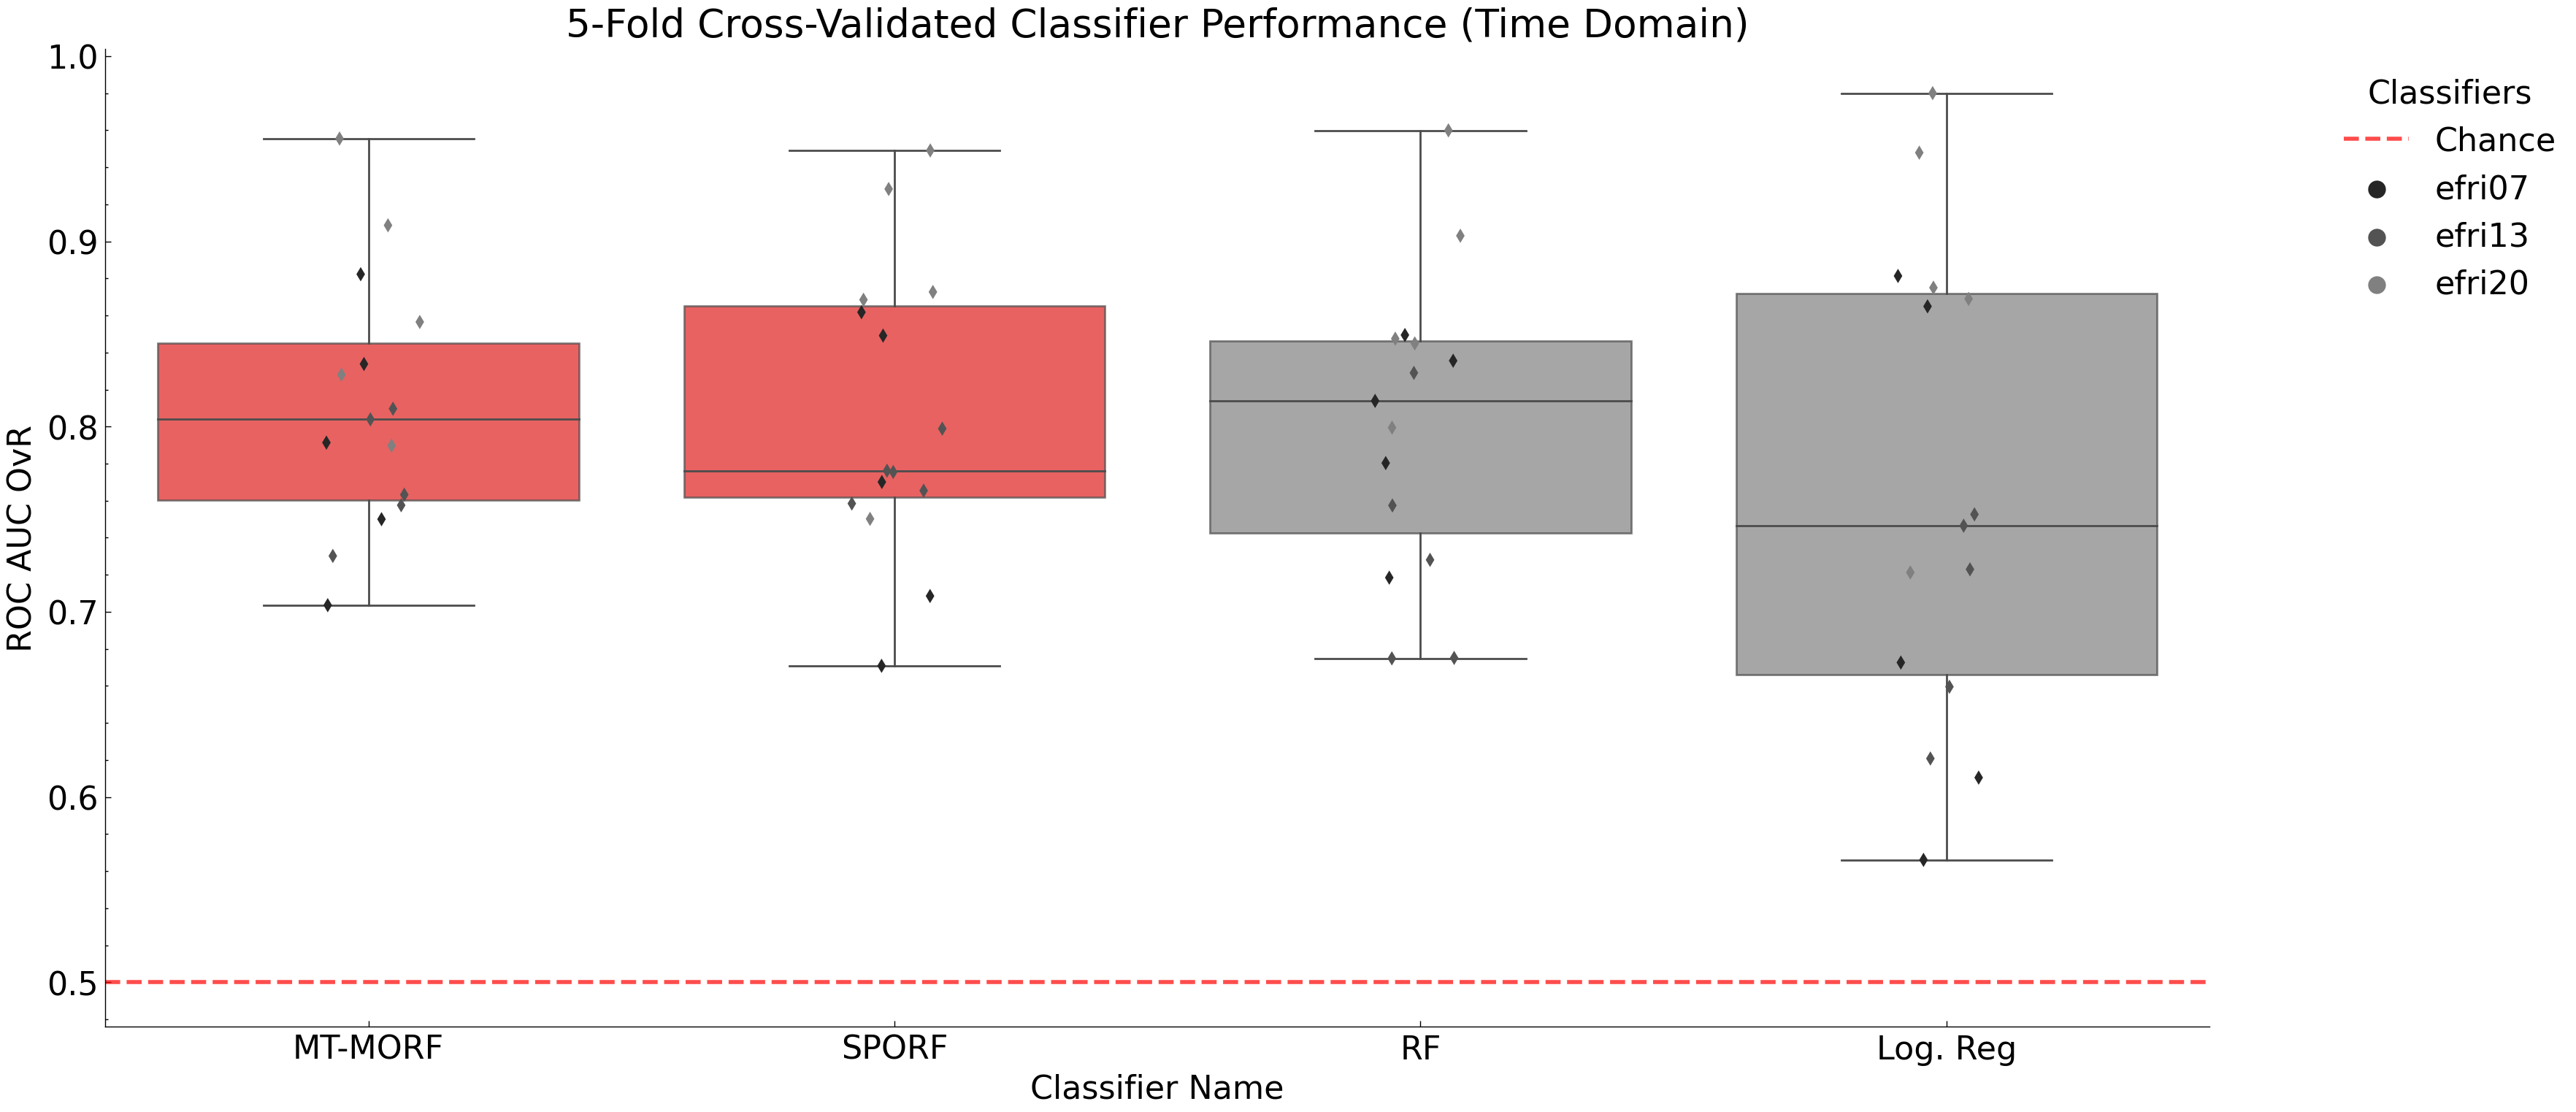

In [277]:
selected_auroc_df = auroc_df[auroc_df.Subject.isin(["efri07", "efri13", "efri20"])]
plt.rcParams.update({"font.size": 16})
fig, ax = plt.subplots(figsize=(18, 8), dpi=200)
sns.stripplot(x="Classifier Name", y="ROC AUC OvR", hue="Subject", marker='d', data=selected_auroc_df, dodge=False, ax=ax, color="gray")
palette = {"MT-MORF": "r", "SPORF": "r", "RF": "gray", "Log. Reg": "gray"}
sns.boxplot(x="Classifier Name", y="ROC AUC OvR", data=selected_auroc_df, dodge=False, boxprops=dict(alpha=0.7), ax=ax, palette=palette)
ax.axhline(0.5, label="Chance", ls="--", lw=2, c='r', alpha=0.7)
ax.set_title(f"{n_splits}-Fold Cross-Validated Classifier Performance (Time Domain)")
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(axis='x', which='minor', bottom=False)
ax.legend(title='Classifiers', bbox_to_anchor=(1.05, 1), loc='upper left')
fig.tight_layout();

## Frequency Domain (02-24-21)

In [73]:
import json
subjects = metadata["subjects"]

subject_clf_scores = {}
clf_names = ["MT-MORF", "S-RerF", "RandomForestClassifier", "LogisticRegression"]
new_names = ["MT-MORF", "SPORF", "RF", "LR"]
for subject in subjects:
    if subject == "efri25":
        continue
    subject_clf_scores[subject] = {}
    for clf_name, new_name in zip(clf_names, new_names):
        with open(
            derivatives_path 
            / f"workstation_output/{subject}/trial_specific_window/freq_domain/{subject}_{clf_name}_results.json", "r"
        ) as f:
            subject_clf_scores[subject][new_name] = json.load(f)

auroc_df = []
for subject, clf_scores in subject_clf_scores.items():
    for clf_name, scores in clf_scores.items():
        auroc_df.append([subject, clf_name, scores["test_roc_auc_ovr"]])
auroc_df = pd.DataFrame(auroc_df, columns=["Subject", "Classifier Name", "ROC AUC OvR"])
auroc_df = pd.DataFrame({"Subject": np.repeat(auroc_df["Subject"].values, auroc_df["ROC AUC OvR"].str.len()),
                         "Classifier Name": np.repeat(auroc_df["Classifier Name"].values, auroc_df["ROC AUC OvR"].str.len()),
                         'ROC AUC OvR':np.concatenate(auroc_df["ROC AUC OvR"].values)})

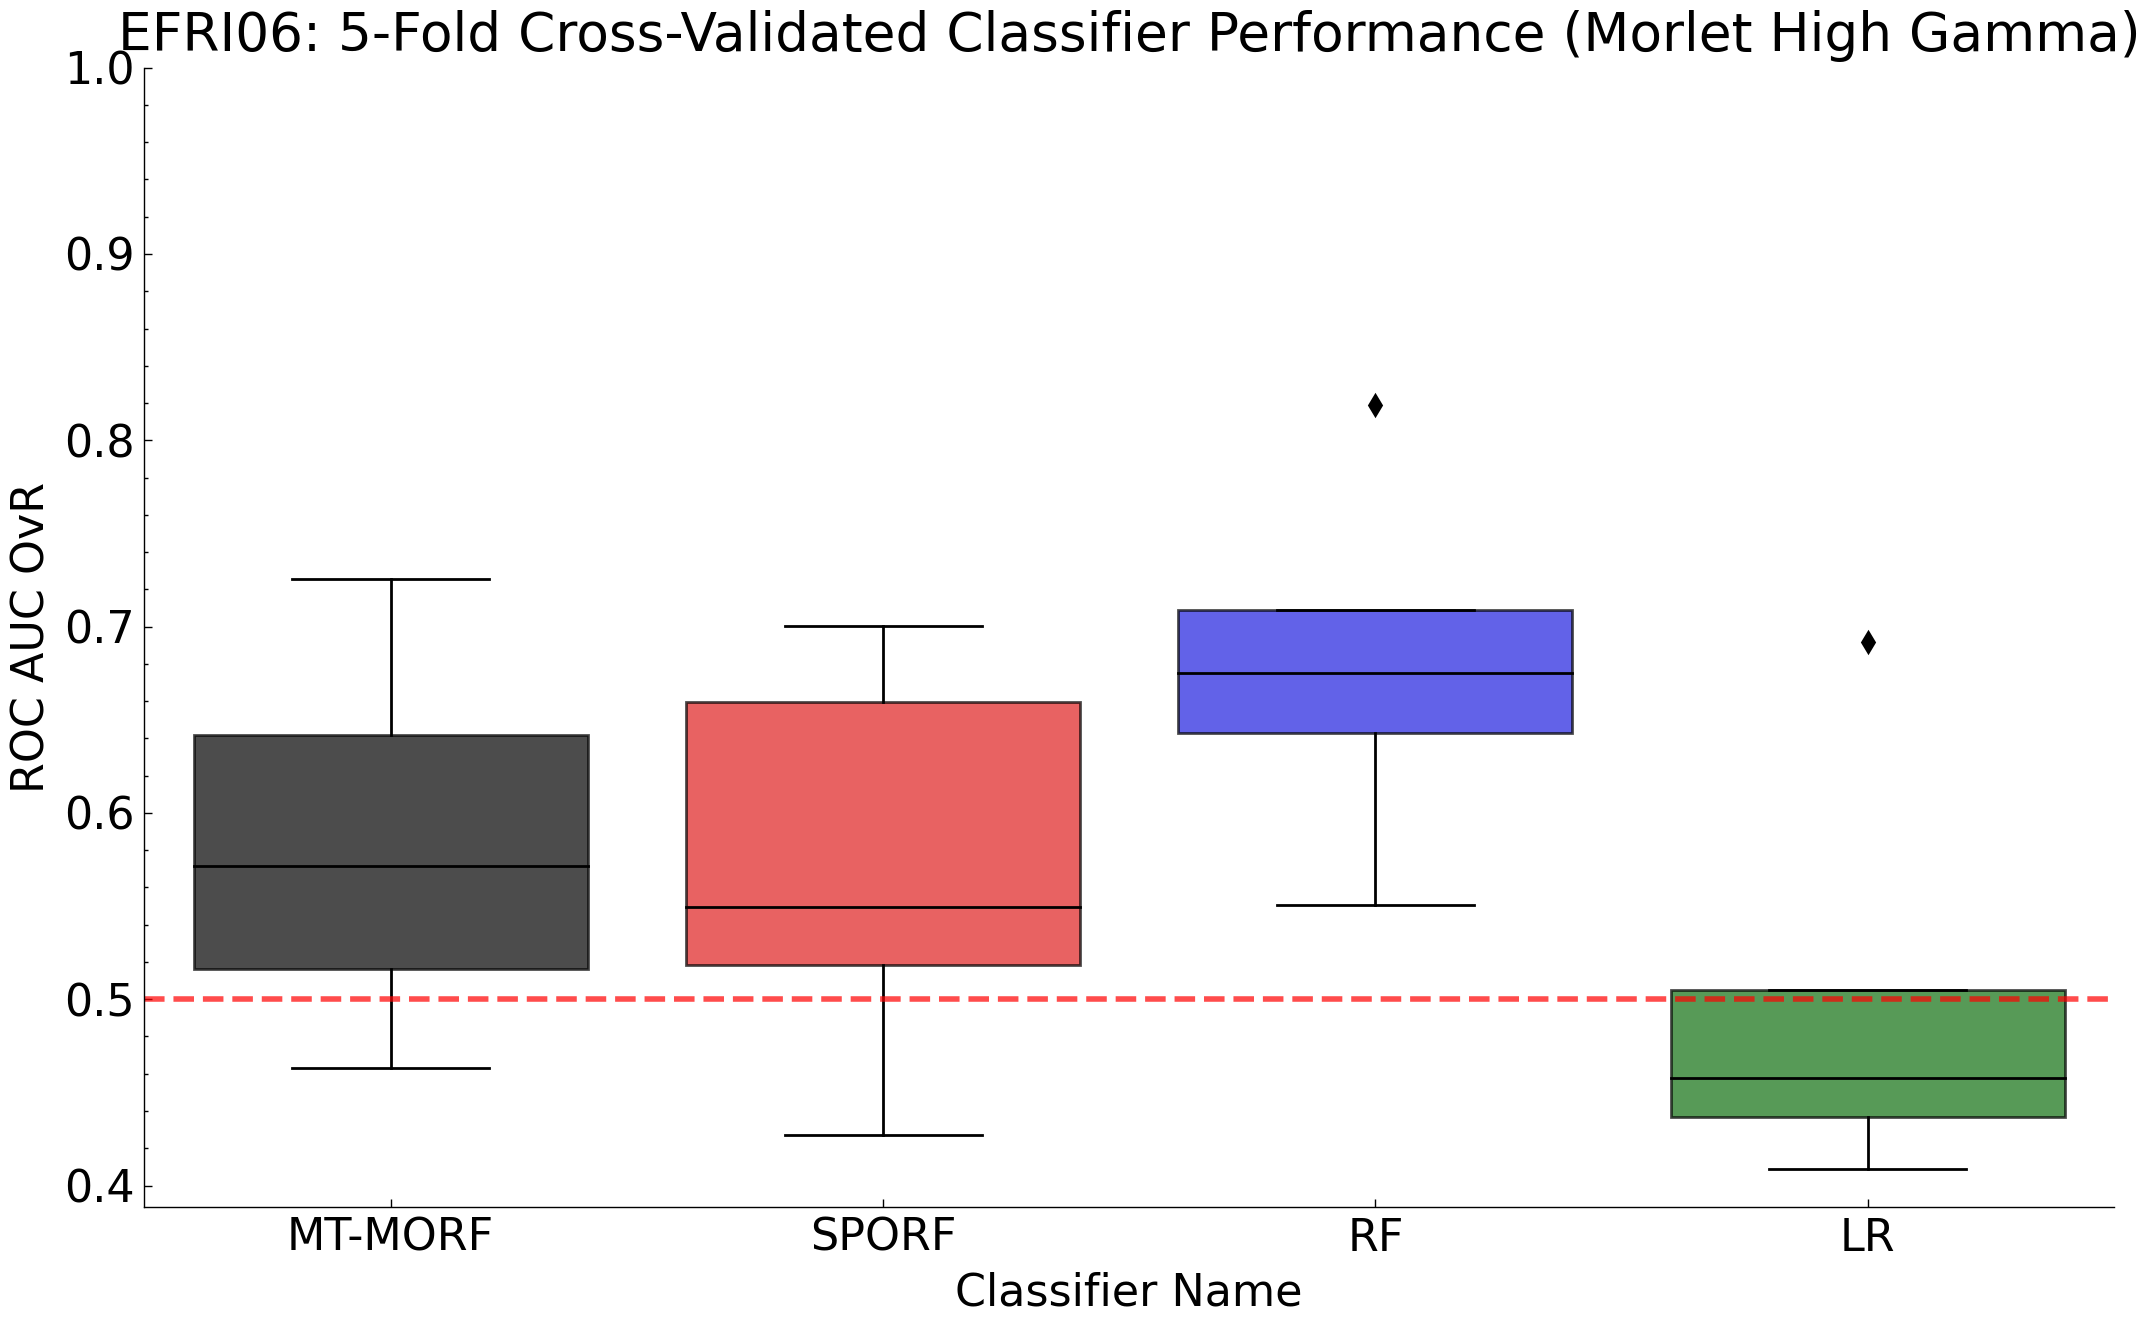

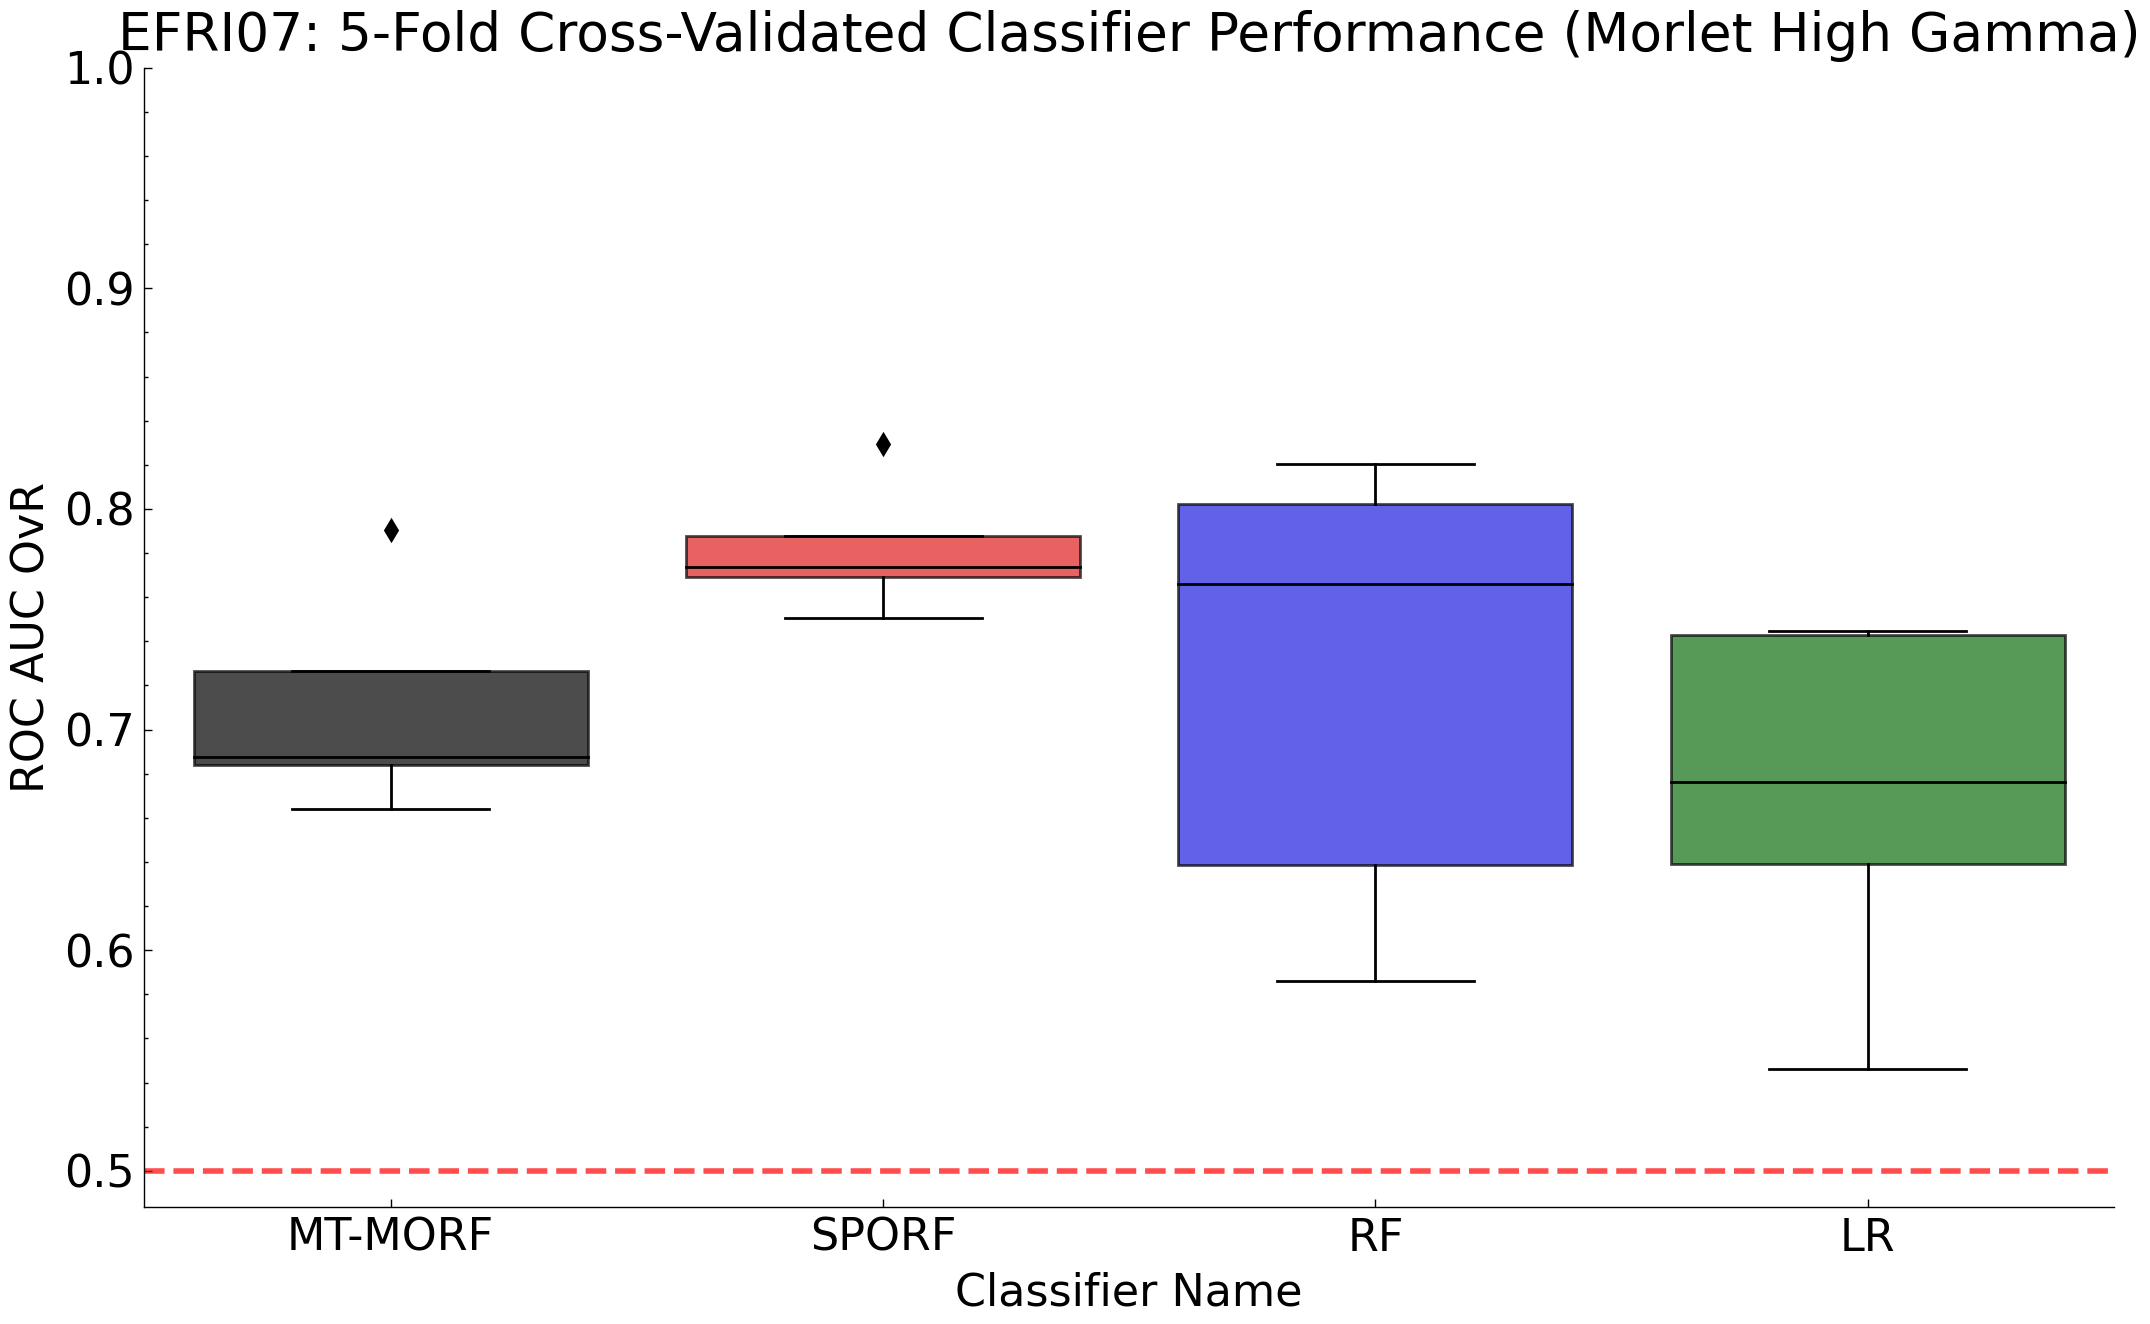

In [78]:
selected_subjects = ["efri06", "efri07"]
for subject in selected_subjects:
    df = auroc_df[auroc_df.Subject == subject]
    plt.rcParams.update({"font.size": 16})
    fig, ax = plt.subplots(figsize=(11, 7), dpi=200)
    sns.boxplot(x="Classifier Name", y="ROC AUC OvR", data=df, dodge=True, boxprops=dict(alpha=0.7), ax=ax)
    ax.axhline(0.5, label="Chance", ls="--", lw=2, c='r', alpha=0.7)
    ax.set_title(f"{subject.upper()}: {n_splits}-Fold Cross-Validated Classifier Performance (Morlet High Gamma)")
    ax.set_ylim(None, 1)
    
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.tick_params(axis='x', which='minor', bottom=False)
    fig.tight_layout()
    plt.show()

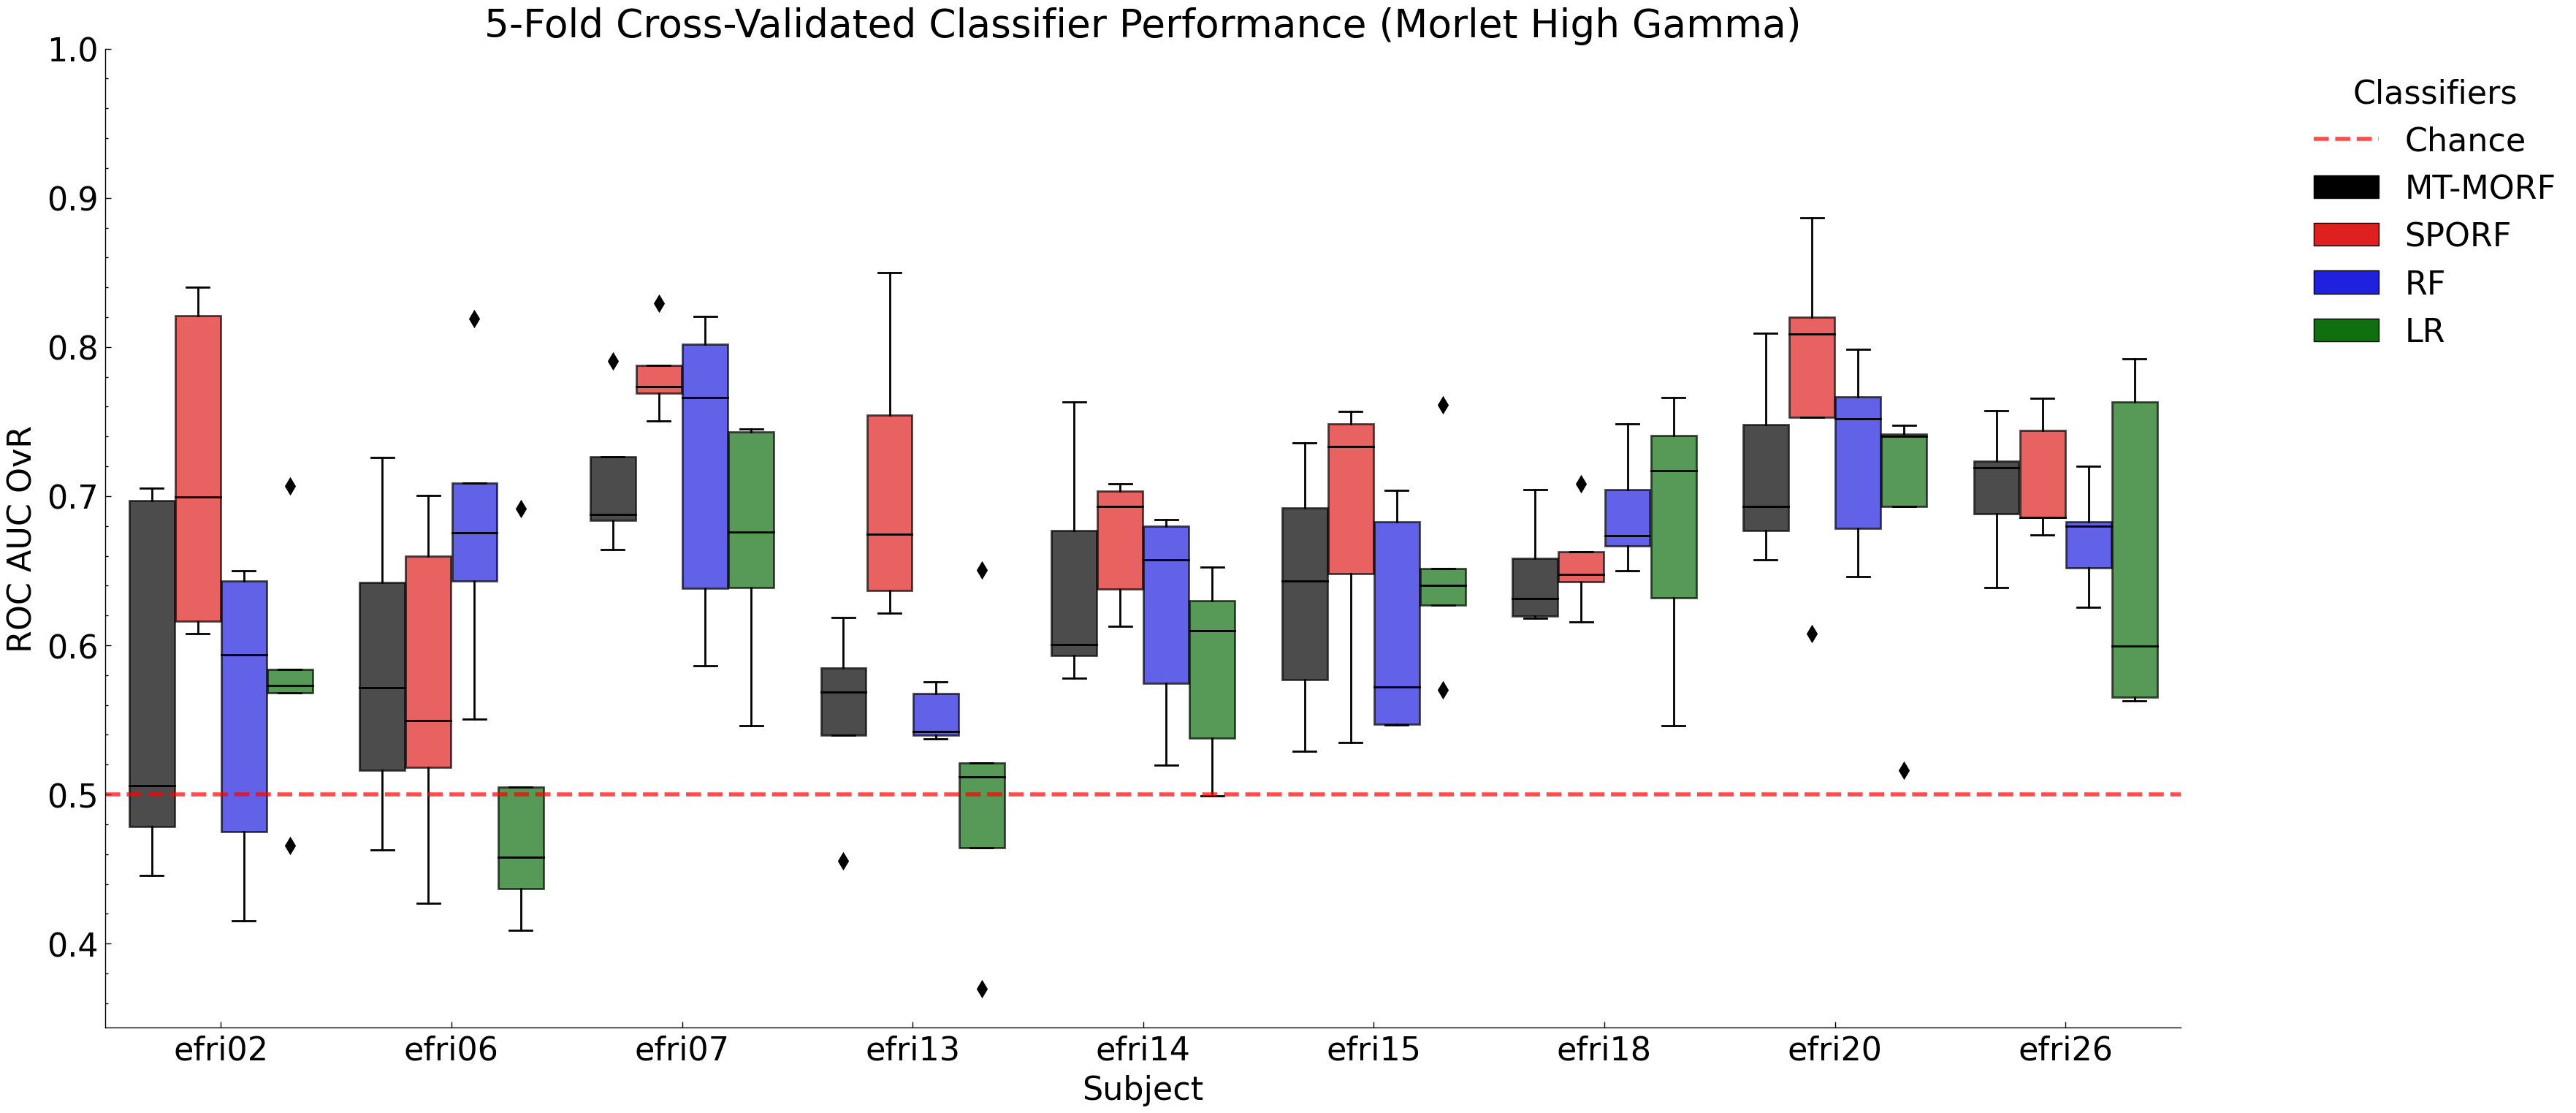

In [79]:
plt.rcParams.update({"font.size": 16})
fig, ax = plt.subplots(figsize=(18, 8), dpi=200)
sns.boxplot(x="Subject", y="ROC AUC OvR", hue="Classifier Name", data=auroc_df, dodge=True, boxprops=dict(alpha=0.7), ax=ax)
ax.axhline(0.5, label="Chance", ls="--", lw=2, c='r', alpha=0.7)
ax.set_title(f"{n_splits}-Fold Cross-Validated Classifier Performance (Morlet High Gamma)")
ax.set_ylim(None, 1)
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(axis='x', which='minor', bottom=False)
ax.legend(title='Classifiers', bbox_to_anchor=(1.05, 1), loc='upper left')
fig.tight_layout();

## Hilbert Transform (03-25-21)

In [82]:
import json
subjects = metadata["subjects"]

subject_clf_scores = {}
clf_names = ["MT-MORF", "S-RerF", "RandomForestClassifier", "LogisticRegression"]
new_names = ["MT-MORF", "SPORF", "RF", "LR"]
for subject in subjects:
    subject_clf_scores[subject] = {}
    for clf_name, new_name in zip(clf_names, new_names):
        with open(
            results_path 
            / f"decode_directionality/{subject}/tmin=-0.2_tmax=0.5/freq_domain/{subject}_{clf_name}_results.json", "r"
        ) as f:
            subject_clf_scores[subject][new_name] = json.load(f)

auroc_df = []
for subject, clf_scores in subject_clf_scores.items():
    for clf_name, scores in clf_scores.items():
        auroc_df.append([subject, clf_name, scores["test_roc_auc_ovr"]])
auroc_df = pd.DataFrame(auroc_df, columns=["Subject", "Classifier Name", "ROC AUC OvR"])
auroc_df = pd.DataFrame({"Subject": np.repeat(auroc_df["Subject"].values, auroc_df["ROC AUC OvR"].str.len()),
                         "Classifier Name": np.repeat(auroc_df["Classifier Name"].values, auroc_df["ROC AUC OvR"].str.len()),
                         'ROC AUC OvR':np.concatenate(auroc_df["ROC AUC OvR"].values)})

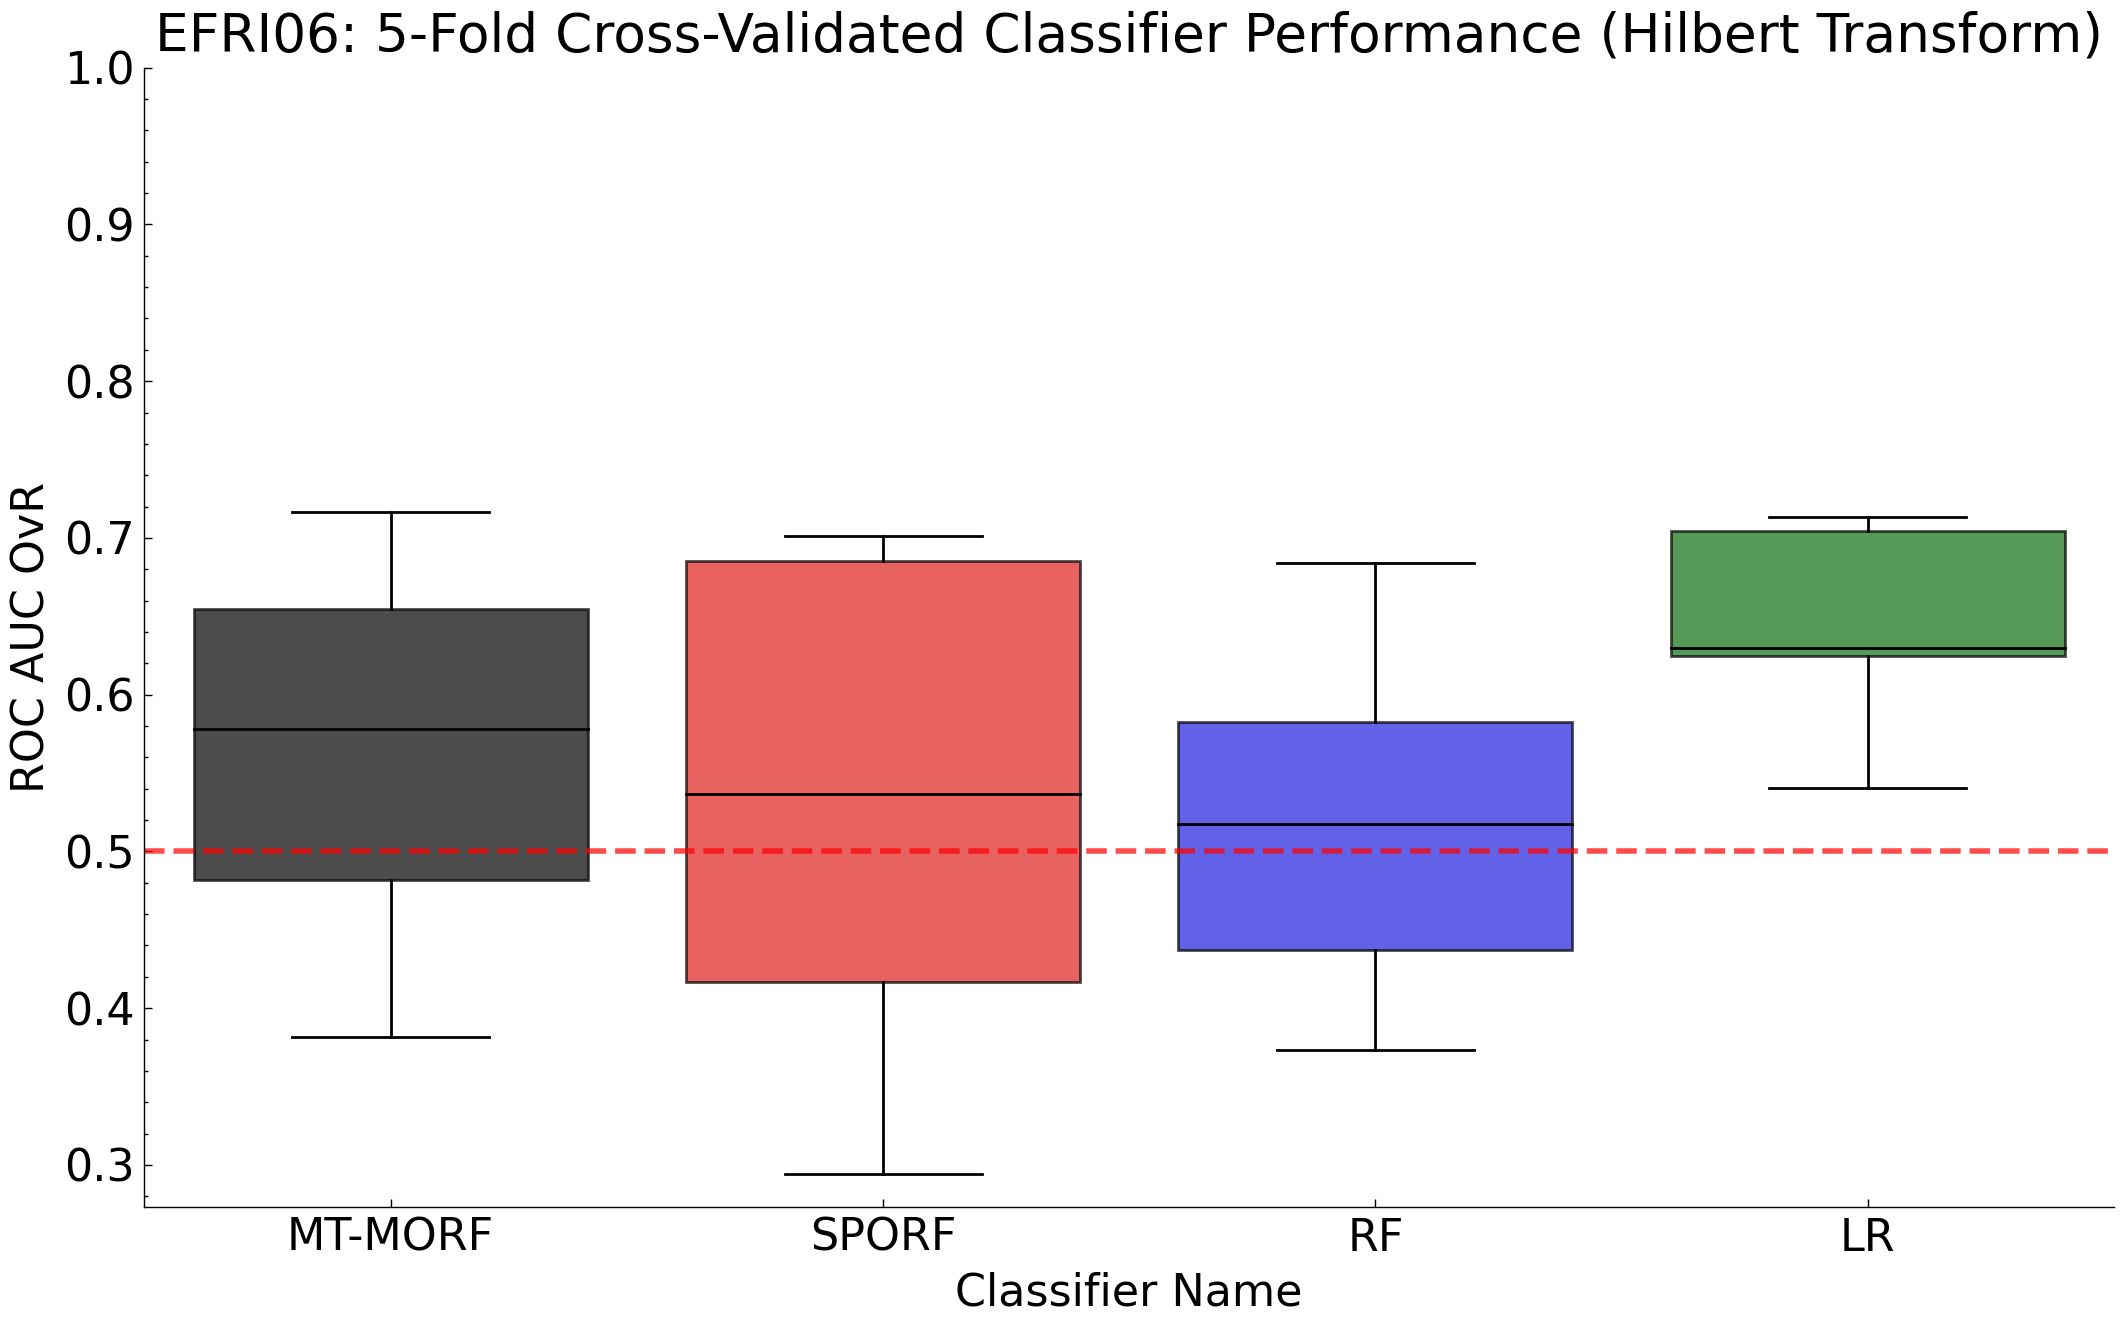

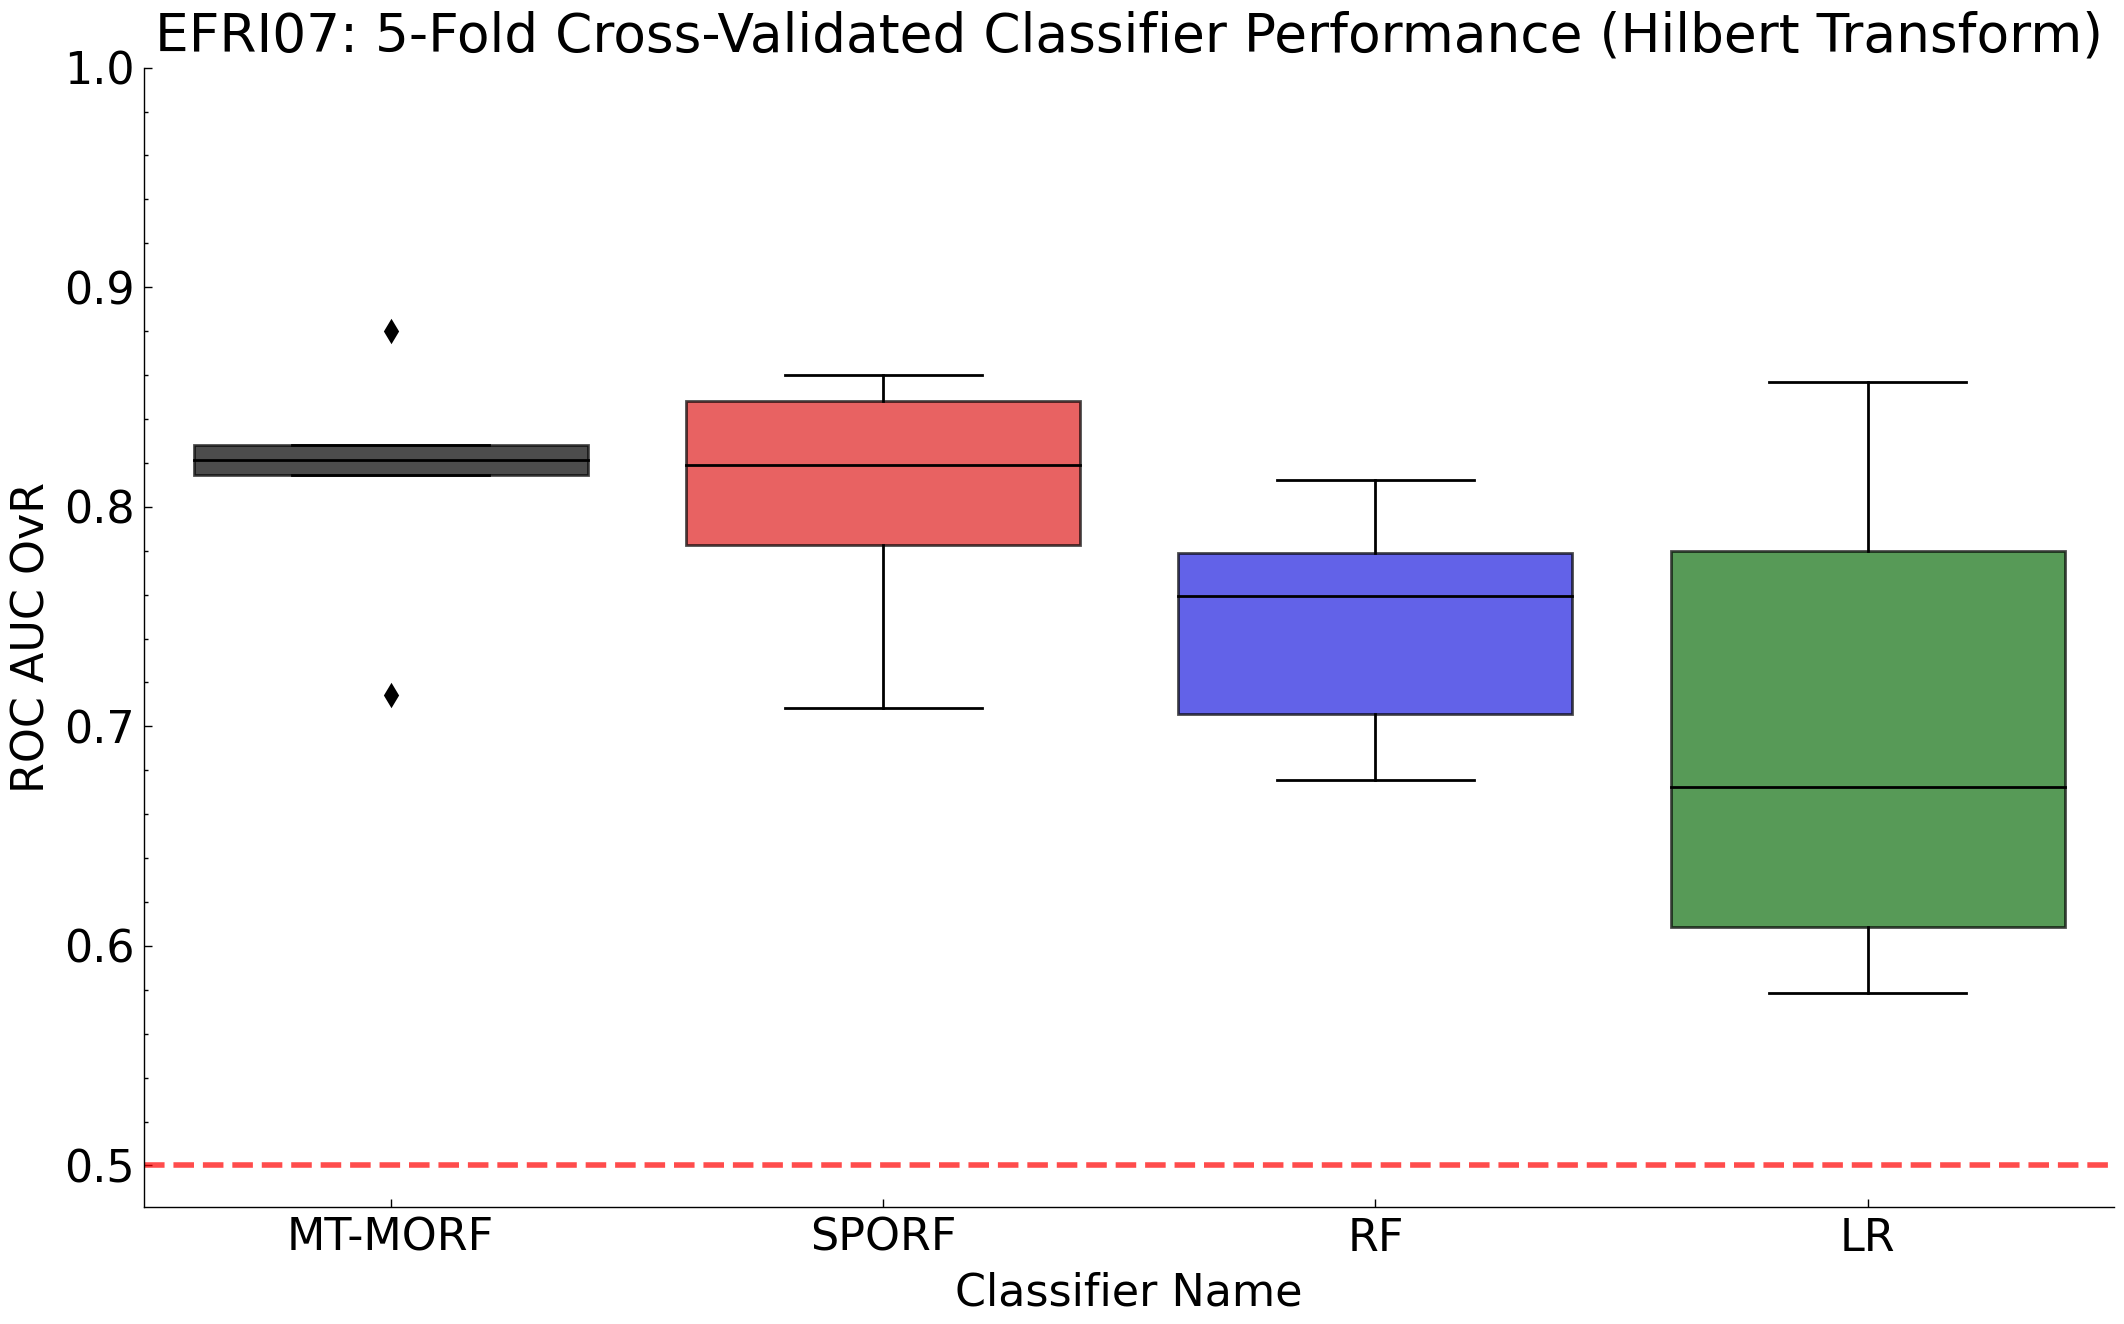

In [83]:
selected_subjects = ["efri06", "efri07"]
for subject in selected_subjects:
    df = auroc_df[auroc_df.Subject == subject]
    plt.rcParams.update({"font.size": 16})
    fig, ax = plt.subplots(figsize=(11, 7), dpi=200)
    sns.boxplot(x="Classifier Name", y="ROC AUC OvR", data=df, dodge=True, boxprops=dict(alpha=0.7), ax=ax)
    ax.axhline(0.5, label="Chance", ls="--", lw=2, c='r', alpha=0.7)
    ax.set_title(f"{subject.upper()}: {n_splits}-Fold Cross-Validated Classifier Performance (Hilbert Transform)")
    ax.set_ylim(None, 1)
    
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.tick_params(axis='x', which='minor', bottom=False)
    fig.tight_layout()
    plt.show()

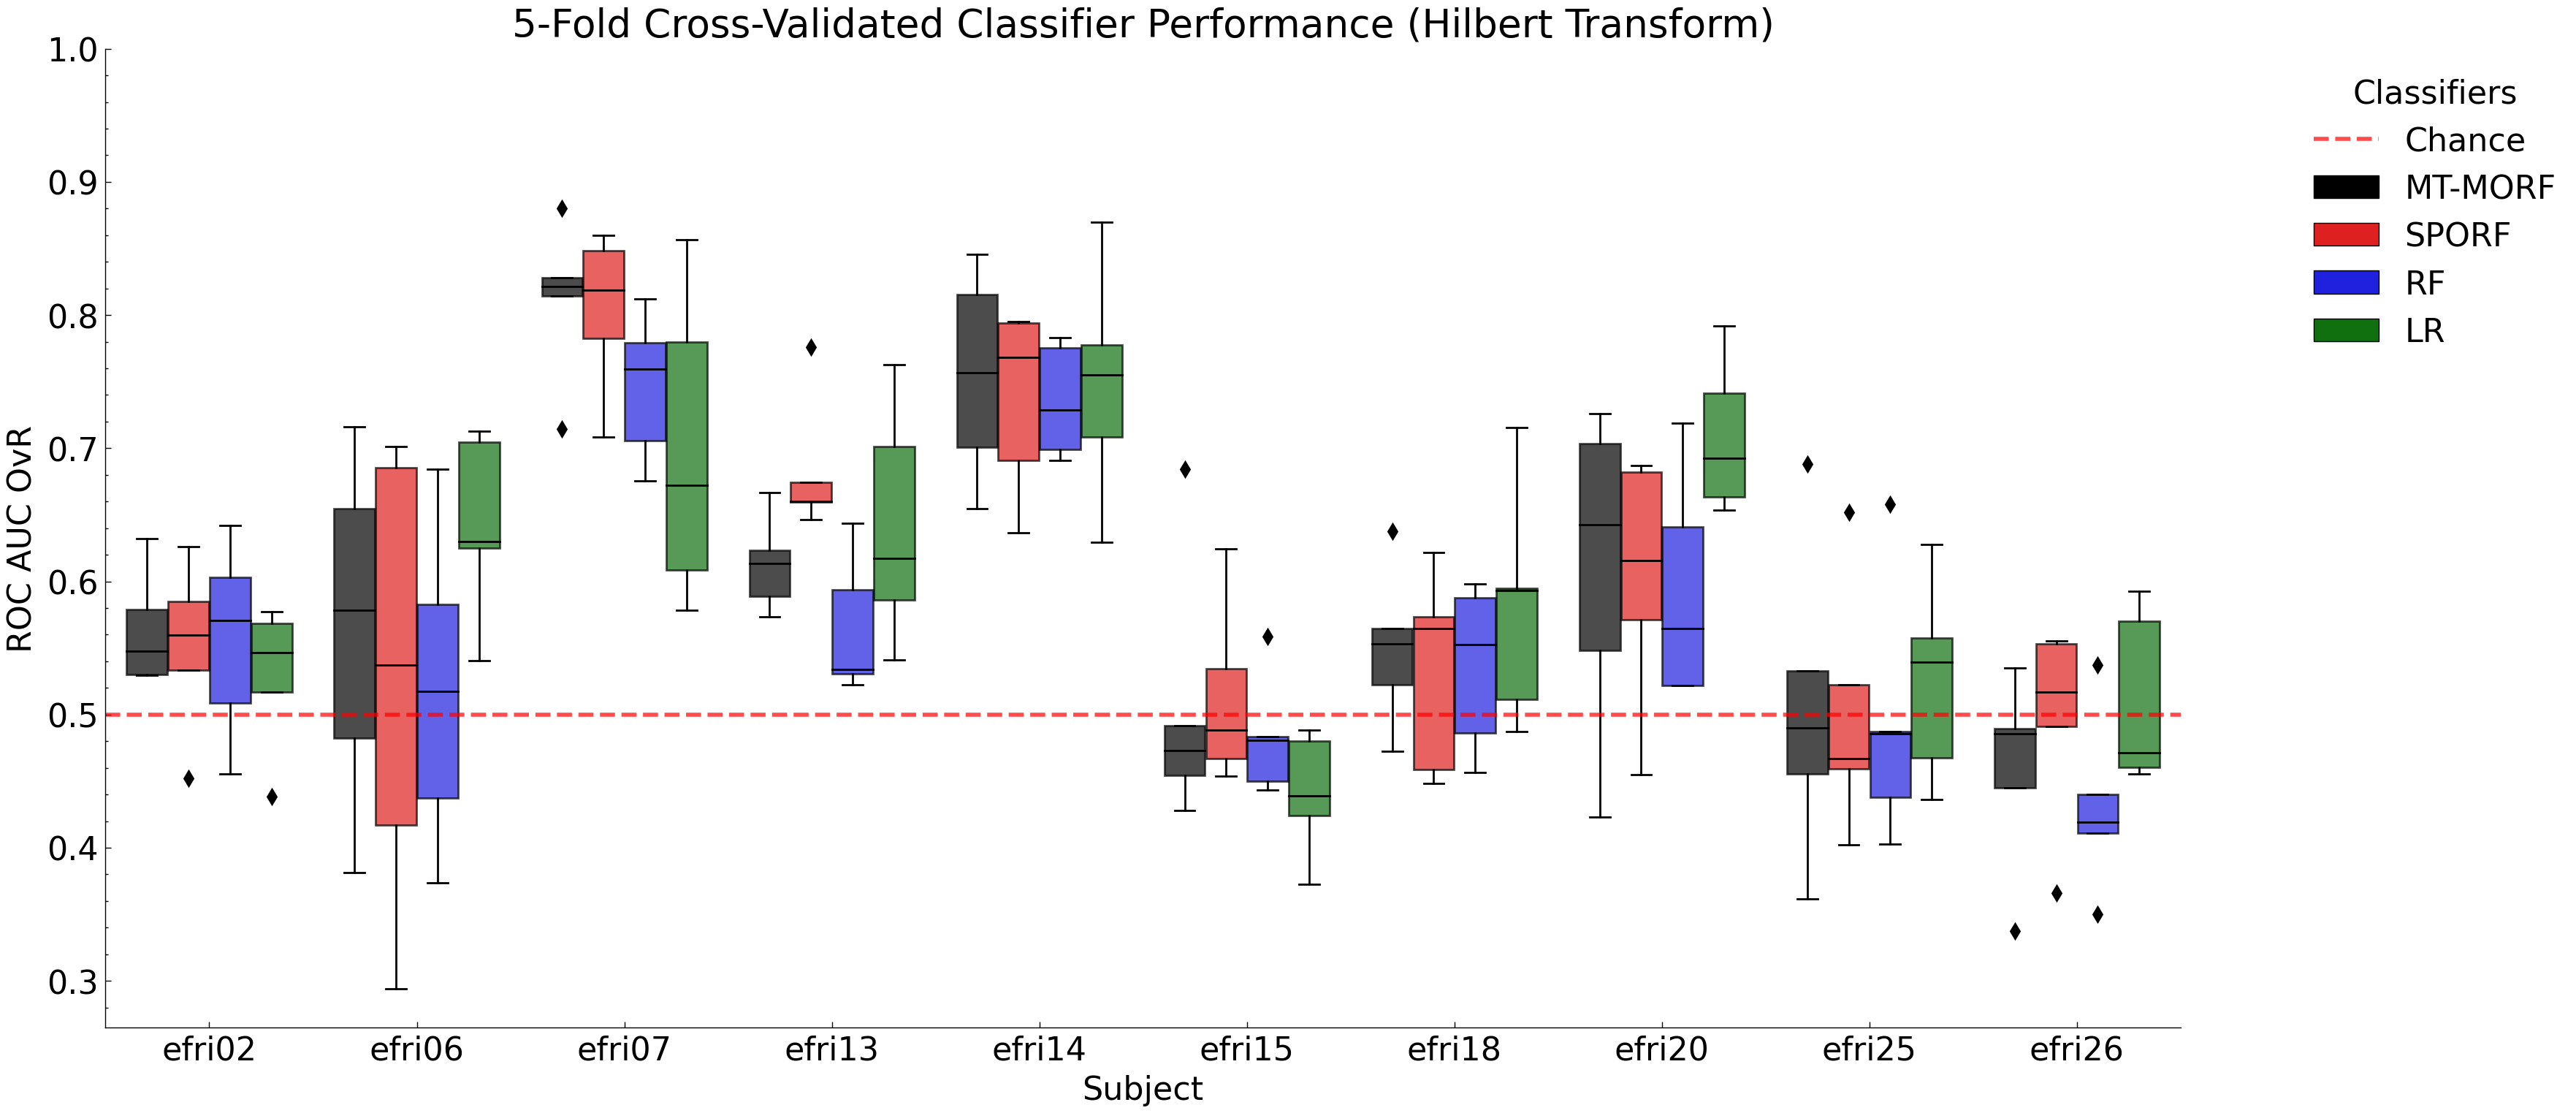

In [84]:
plt.rcParams.update({"font.size": 16})
fig, ax = plt.subplots(figsize=(18, 8), dpi=200)
sns.boxplot(x="Subject", y="ROC AUC OvR", hue="Classifier Name", data=auroc_df, dodge=True, boxprops=dict(alpha=0.7), ax=ax)
ax.axhline(0.5, label="Chance", ls="--", lw=2, c='r', alpha=0.7)
ax.set_title(f"{n_splits}-Fold Cross-Validated Classifier Performance (Hilbert Transform)")
ax.set_ylim(None, 1)
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(axis='x', which='minor', bottom=False)
ax.legend(title='Classifiers', bbox_to_anchor=(1.05, 1), loc='upper left')
fig.tight_layout();

# Permutation Importance

## Time Domain (03-25-21)

In [86]:
import json
subjects = metadata["subjects"]

subject_scores = {}
for subject in subjects:
    with open(
        results_path 
        / f"decode_directionality/{subject}/hilbert_transform/{subject}_MT-MORF_time_domain.json", "r"
    ) as f:
        subject_scores[subject] = json.load(f)

In [87]:
subject_scores["efri07"].keys()

dict_keys(['fit_time', 'score_time', 'test_accuracy', 'test_cohen_kappa_score', 'test_roc_auc_ovr', 'train_predict_proba', 'train_preds', 'train_inds', 'train_fpr', 'train_tpr', 'train_fnr', 'train_tnr', 'train_thresholds', 'train_confusion_matrix', 'test_predict_proba', 'test_preds', 'test_inds', 'test_fpr', 'test_tpr', 'test_fnr', 'test_tnr', 'test_thresholds', 'test_confusion_matrix', 'model_params', 'validate_roc_auc_ovr_imp_mean', 'validate_roc_auc_ovr_importances', 'validate_roc_auc_ovr_patch_inds', 'validate_roc_auc_ovr_usage_counts'])

In [94]:
from mtsmorf.move_exp.plotting import plot_feature_importances
from mtsmorf.io.move.read import read_move_trial_epochs

subject = 'efri07'
epochs = read_move_trial_epochs(bids_root, subject, resample_rate=None)
epochs.load_data()
epochs_resampled = epochs.filter(1, epochs.info["sfreq"] / 2. - 1).resample(resample_rate)
epochs_data = epochs_resampled.get_data()
ntrials, nchs, nsteps = epochs_data.shape

image_height = nchs
image_width = nsteps
result = {
    "importances_mean": np.array(subject_scores[subject]["validate_roc_auc_ovr_imp_mean"]),
    "importances": np.array(subject_scores[subject]["validate_roc_auc_ovr_importances"]),
    "patch_inds": np.array(subject_scores[subject]["validate_roc_auc_ovr_patch_inds"]),
    "usage_counts": np.array(subject_scores[subject]["validate_roc_auc_ovr_usage_counts"])
}

Analyzing bids dataset: /Users/ChesterHuynh/OneDrive - Johns Hopkins/efri/sub-efri07/ses-efri/ieeg/sub-efri07_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr with tmin=-0.2 and tmax=0.5 time-locked to Left Target.
Loaded in behavioral df: Index(['trial_id', 'successful_trial_flag', 'reaction_time', 'n_reaction_time',
       'r_reaction_time', 'missed_target_flag', 'speed_instruction',
       'speed_ratio', 'correct_speed_flag', 'force_angular', 'force_magnitude',
       'target_direction', 'x_position', 'y_position'],
      dtype='object')
Extracting parameters from /Users/ChesterHuynh/OneDrive - Johns Hopkins/efri/sub-efri07/ses-efri/ieeg/sub-efri07_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr...
Setting channel info structure...
Reading events from /Users/ChesterHuynh/OneDrive - Johns Hopkins/efri/sub-efri07/ses-efri/ieeg/sub-efri07_ses-efri_task-move_acq-seeg_run-01_events.tsv.
Reading channel info from /Users/ChesterHuynh/OneDrive - Johns Hopkins/efri/sub-efri07/ses-efri/ieeg/sub-efri

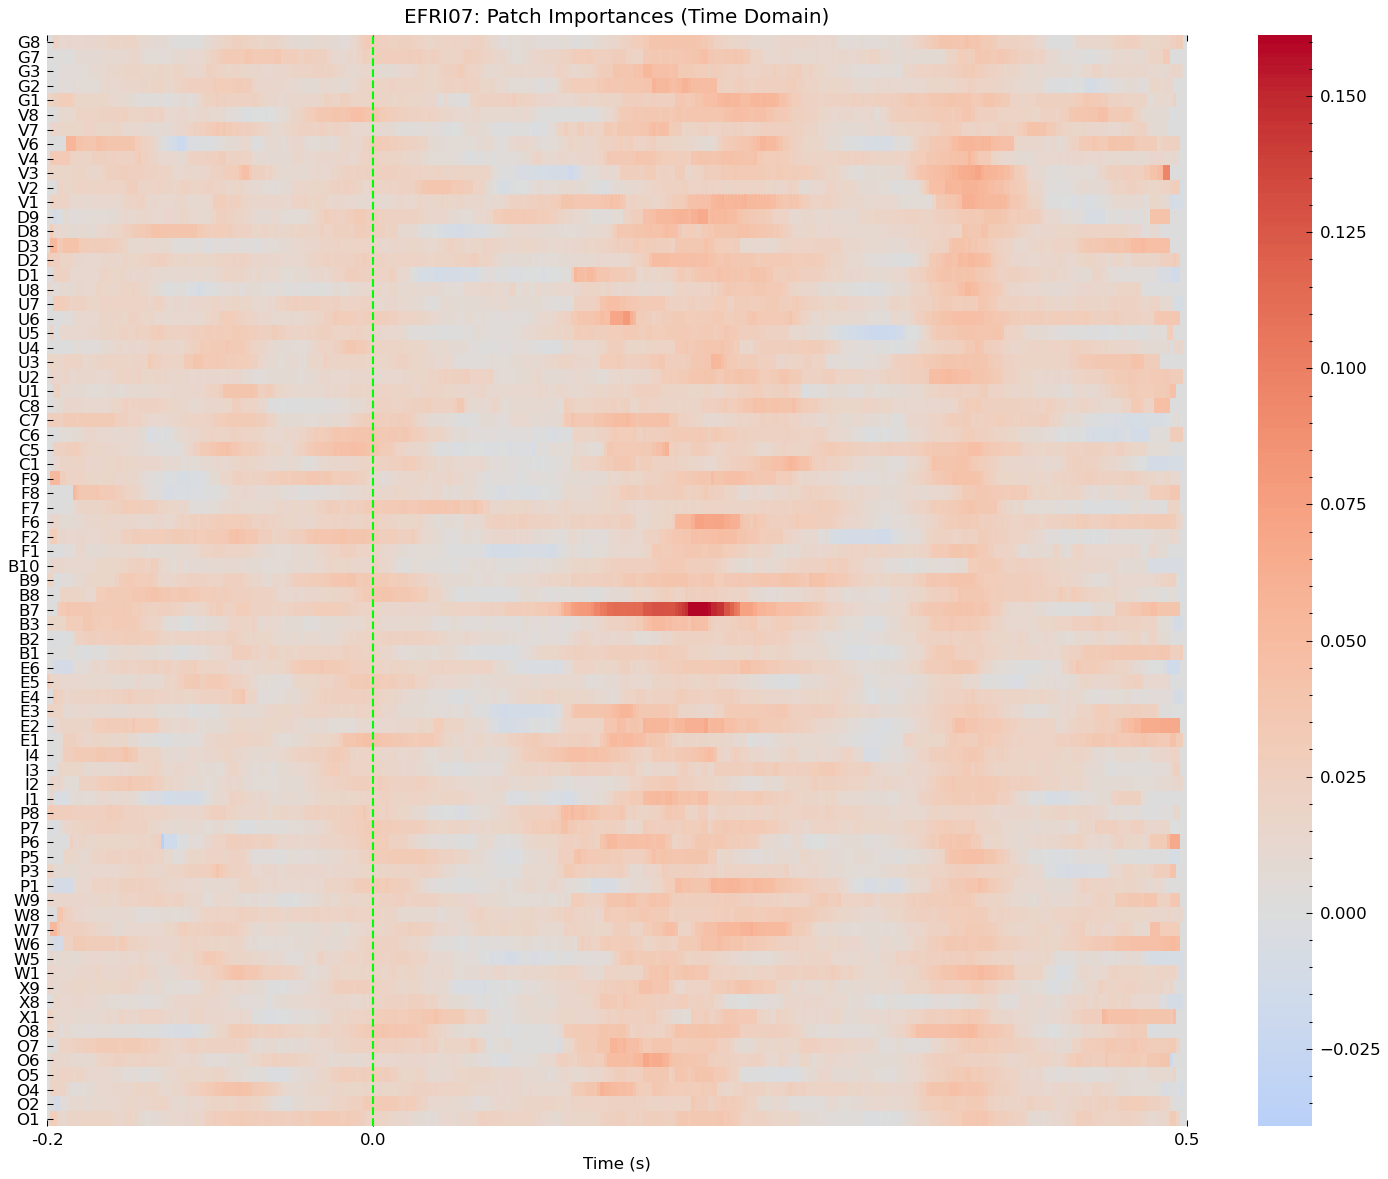

In [104]:
fig, ax = plt.subplots(dpi=150, figsize=(10, 8))
plot_feature_importances(result, epochs.ch_names, epochs_resampled.times, image_height, image_width, vmin=None, vmax=None, ax=ax)
ax.set_title(f"{subject.upper()}: Patch Importances (Time Domain)")
ax.tick_params(axis='x', which='minor', bottom=False)
ax.tick_params(axis='x', which='minor', top=False)
ax.tick_params(axis='y', which='minor', left=False, right=False)
ax.tick_params(axis='y', which='major', right=False)
fig.tight_layout();

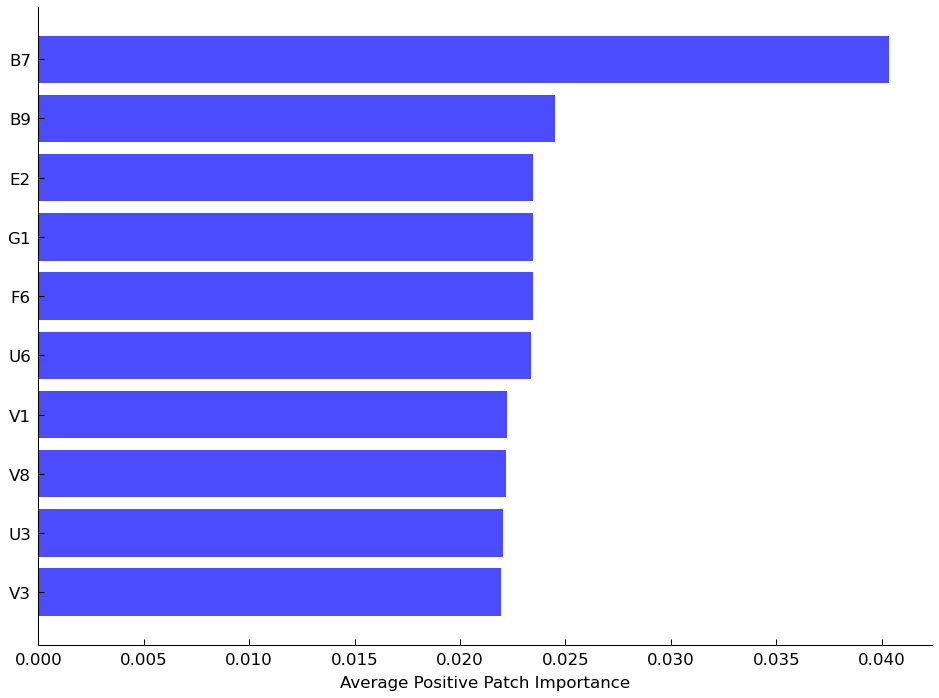

In [126]:
fig, ax = plt.subplots(dpi=150, figsize=(6.4, 4.8))
imp_mean = np.array(result["importances_mean"])
imp_mean[imp_mean <= 0] = 0.0
imp_double_mean = np.mean(imp_mean, axis=1)
order = np.argsort(imp_double_mean)
ax.barh(np.array(epochs.ch_names)[order[-10:]], imp_double_mean[order[-10:]], color="blue", alpha=0.7)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(axis='x', which='minor', bottom=False)
ax.tick_params(axis='y', which='minor', left=False)
ax.set_xlabel("Average Positive Patch Importance")
fig.tight_layout();

In [133]:
from mtsmorf.io.read import _get_anatomical_bad_chs

channels = []
path_identifiers = dict(
    subject=subjects[0],
    session="efri",
    task="move",
    acquisition="seeg",
    run="01",
    suffix="ieeg",
    extension=".vhdr",
    root=bids_root
)
for subject in subjects:
    path_identifiers["subject"] = subject
    path_identifiers["extension"] = ".tsv"
    bids_path = BIDSPath(**path_identifiers)
    bids_path.update(suffix="channels")
    bads = _get_anatomical_bad_chs(bids_path)
    
    tmp = _from_tsv(bids_path)
    tmp = [
        (name, anat, subject) 
        for (name, anat) in zip(tmp["name"], tmp["anat"]) 
        if name not in bads
    ]

    channels.extend(tmp)

channels = pd.DataFrame(channels, columns=["name", "anat", "subject"])
channels.head()
sorted_channels = channels.sort_values(["anat", "subject"])

In [141]:
top_channels = sorted_channels[(channels.name.isin(np.array(epochs.ch_names)[order[-10:]])) & (sorted_channels.subject == "efri07")]
top_chs_anat = top_channels.anat.unique()
print(*top_chs_anat, sep="\n")

    name                                          anat subject
158   V3                                      cuneus R  efri07
160   V1                                      cuneus R  efri07
196   E2                           entorhinal cortex R  efri07
182   F6                    inferior temporal sulcus R  efri07
153   G1                               lingula gyrus R  efri07
186   B9                       middle temporal gyrus R  efri07
188   B7                       middle temporal gyrus R  efri07
154   V8                             occipital gyrus R  efri07
168   U6  superior temporal gyrus (planum temporale) R  efri07
171   U3  superior temporal gyrus (planum temporale) R  efri07
cuneus R
entorhinal cortex R
inferior temporal sulcus R
lingula gyrus R
middle temporal gyrus R
occipital gyrus R
superior temporal gyrus (planum temporale) R
<ipython-input-141-7099a9500ef4>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  top_channels = sorted_channels[(ch

In [147]:
top_channels

name                                          anat subject
158   V3                                      cuneus R  efri07
160   V1                                      cuneus R  efri07
196   E2                           entorhinal cortex R  efri07
182   F6                    inferior temporal sulcus R  efri07
153   G1                               lingula gyrus R  efri07
186   B9                       middle temporal gyrus R  efri07
188   B7                       middle temporal gyrus R  efri07
154   V8                             occipital gyrus R  efri07
168   U6  superior temporal gyrus (planum temporale) R  efri07
171   U3  superior temporal gyrus (planum temporale) R  efri07

In [216]:
top_performers_time_domain = ["efri07", "efri13", "efri14", "efri18", "efri20"]
top_channels_df = {}
for subject in top_performers_time_domain:
    epochs = read_move_trial_epochs(bids_root, subject, resample_rate=None)
    epochs.load_data()
    epochs_resampled = epochs.filter(1, epochs.info["sfreq"] / 2. - 1).resample(resample_rate)
    epochs_data = epochs_resampled.get_data()
    ntrials, nchs, nsteps = epochs_data.shape

    image_height = nchs
    image_width = nsteps
    result = {
        "importances_mean": np.array(subject_scores[subject]["validate_roc_auc_ovr_imp_mean"]),
        "importances": np.array(subject_scores[subject]["validate_roc_auc_ovr_importances"]),
        "patch_inds": np.array(subject_scores[subject]["validate_roc_auc_ovr_patch_inds"]),
        "usage_counts": np.array(subject_scores[subject]["validate_roc_auc_ovr_usage_counts"])
    }
    imp_mean = np.array(result["importances_mean"])
    imp_mean[imp_mean <= 0] = 0.0
    imp_double_mean = np.mean(imp_mean, axis=1)
    order = np.argsort(imp_double_mean)
    top_chs = np.array(epochs.ch_names)[order[-10:]]
    top_imps = imp_double_mean[order[-10:]]
    top_channels = sorted_channels[(channels.name.isin(top_chs)) & (sorted_channels.subject == subject)]
    top_channels_df[subject] = top_channels

unsuccessful or perturbed trial.
  warn(f'Cant add xy metrics to unsuccessful or perturbed trial.')
/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/motor-decoding/mtsmorf/io/move/read.py:94: RuntimeWarning: Cant add xy metrics to unsuccessful or perturbed trial.
  warn(f'Cant add xy metrics to unsuccessful or perturbed trial.')
/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/motor-decoding/mtsmorf/io/move/read.py:94: RuntimeWarning: Cant add xy metrics to unsuccessful or perturbed trial.
  warn(f'Cant add xy metrics to unsuccessful or perturbed trial.')
/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/motor-decoding/mtsmorf/io/move/read.py:94: RuntimeWarning: Cant add xy metrics to unsuccessful or perturbed trial.
  warn(f'Cant add xy metrics to unsuccessful or perturbed trial.')
/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/motor-decoding/mtsmorf/io/move/read.py:94: RuntimeWarning: Cant add xy metrics to unsuccessful or perturbed trial.
  warn(f'Cant add xy me

In [217]:
top_channels_all_subjects = pd.concat([df for df in top_channels_df.values()])
top_channels_all_subjects.head()

name                        anat subject
158   V3                    cuneus R  efri07
160   V1                    cuneus R  efri07
196   E2         entorhinal cortex R  efri07
182   F6  inferior temporal sulcus R  efri07
153   G1             lingula gyrus R  efri07

In [218]:
shared_anat = top_channels_all_subjects.groupby("anat")["subject"].nunique()[top_channels_all_subjects.groupby("anat")["subject"].nunique() > 1].index
top_channels_all_subjects[top_channels_all_subjects.anat.isin(shared_anat)]

name                                          anat subject
168    U6  superior temporal gyrus (planum temporale) R  efri07
171    U3  superior temporal gyrus (planum temporale) R  efri07
241   E'8                     inferior temporal gyrus L  efri13
227   B'8                       middle temporal gyrus L  efri13
234   C'8                       middle temporal gyrus L  efri13
251   F'7                       middle temporal gyrus L  efri13
312    X9  superior temporal gyrus (planum temporale) R  efri13
313    X8  superior temporal gyrus (planum temporale) R  efri13
338   F'5                     inferior temporal gyrus L  efri14
321   B'7                       middle temporal gyrus L  efri14
537  F'11                       middle temporal gyrus L  efri18

In [219]:
print(*top_channels_all_subjects[top_channels_all_subjects.anat.isin(shared_anat)].groupby("anat")["subject"])

('inferior temporal gyrus L', 241    efri13
338    efri14
Name: subject, dtype: object) ('middle temporal gyrus L', 227    efri13
234    efri13
251    efri13
321    efri14
537    efri18
Name: subject, dtype: object) ('superior temporal gyrus (planum temporale) R', 168    efri07
171    efri07
312    efri13
313    efri13
Name: subject, dtype: object)


## Hilbert Transform

In [156]:
frequency_bands = dict(
    delta=(0.5, 4),
    theta=(4, 8),
    alpha=(8, 13),
    beta=(13, 30),
    gamma=(30, 70),
    hi_gamma=(70, 200),
)
subjects = metadata["subjects"]
subject_scores_bands = {}
for subject in subjects:
    subject_scores_bands[subject] = {}
    for band in frequency_bands:
        with open(
            results_path 
            / f"decode_directionality/{subject}/hilbert_transform/{subject}_MT-MORF_{band}.json", "r"
        ) as f:
            subject_scores_bands[subject][band] = json.load(f)

In [166]:
top_channels_by_band = {}
for band in frequency_bands:
    band_imps = subject_scores_bands["efri07"][band]
    result = {
        "importances_mean": np.array(band_imps["validate_roc_auc_ovr_imp_mean"]),
        "importances": np.array(band_imps["validate_roc_auc_ovr_importances"]),
        "patch_inds": np.array(band_imps["validate_roc_auc_ovr_patch_inds"]),
        "usage_counts": np.array(band_imps["validate_roc_auc_ovr_usage_counts"])
    }

    imp_mean = np.array(result["importances_mean"])
    imp_mean[imp_mean <= 0] = 0.0
    imp_double_mean = np.mean(imp_mean, axis=1)
    order = np.argsort(imp_double_mean)
    top_channels_by_band[band] = (np.array(epochs.ch_names)[order[-10:]], imp_double_mean[order[-10:]])

In [185]:
top_channels_bands_df = []
for band, (ch_names, imps) in top_channels_by_band.items():
    new_names = [f"{ch}-{band}" for ch in ch_names]
    top_channels_bands_df.extend(list(zip(new_names, imps, ch_names)))
top_channels_bands_df = pd.DataFrame(top_channels_bands_df, columns=["Channel Name", "Average Positive Patch Importance", "name"])
sorted_top_channels = top_channels_bands_df.sort_values("Average Positive Patch Importance", ascending=True)
sorted_top_channels.tail(10)

Channel Name  Average Positive Patch Importance name
40     E3-gamma                           0.045100   E3
41     F1-gamma                           0.045429   F1
42     D2-gamma                           0.045475   D2
43    B10-gamma                           0.046236  B10
44     E6-gamma                           0.046736   E6
45     V6-gamma                           0.046892   V6
46     V7-gamma                           0.046926   V7
47     F7-gamma                           0.048159   F7
48     O2-gamma                           0.048737   O2
49     U1-gamma                           0.049914   U1

In [193]:
sorted_top_channels_w_anat = sorted_top_channels.merge(sorted_channels[sorted_channels.subject == "efri07"], how="left", on="name")
print(*{anat: list(group.name.values) for anat, group in sorted_top_channels_w_anat[-10:].groupby("anat")}.items(), sep="\n")

('cingulate cortex (posterior) R', ['D2'])
('fusiform gyrus R', ['E3', 'F1'])
('inferior temporal gyrus R', ['E6'])
('inferior temporal sulcus R', ['F7'])
('insular cortex (posterior) R', ['U1'])
('middle temporal gyrus R', ['B10'])
('occipital gyrus R', ['V6', 'V7'])
('orbitofrontal cortex (mesial) R', ['O2'])


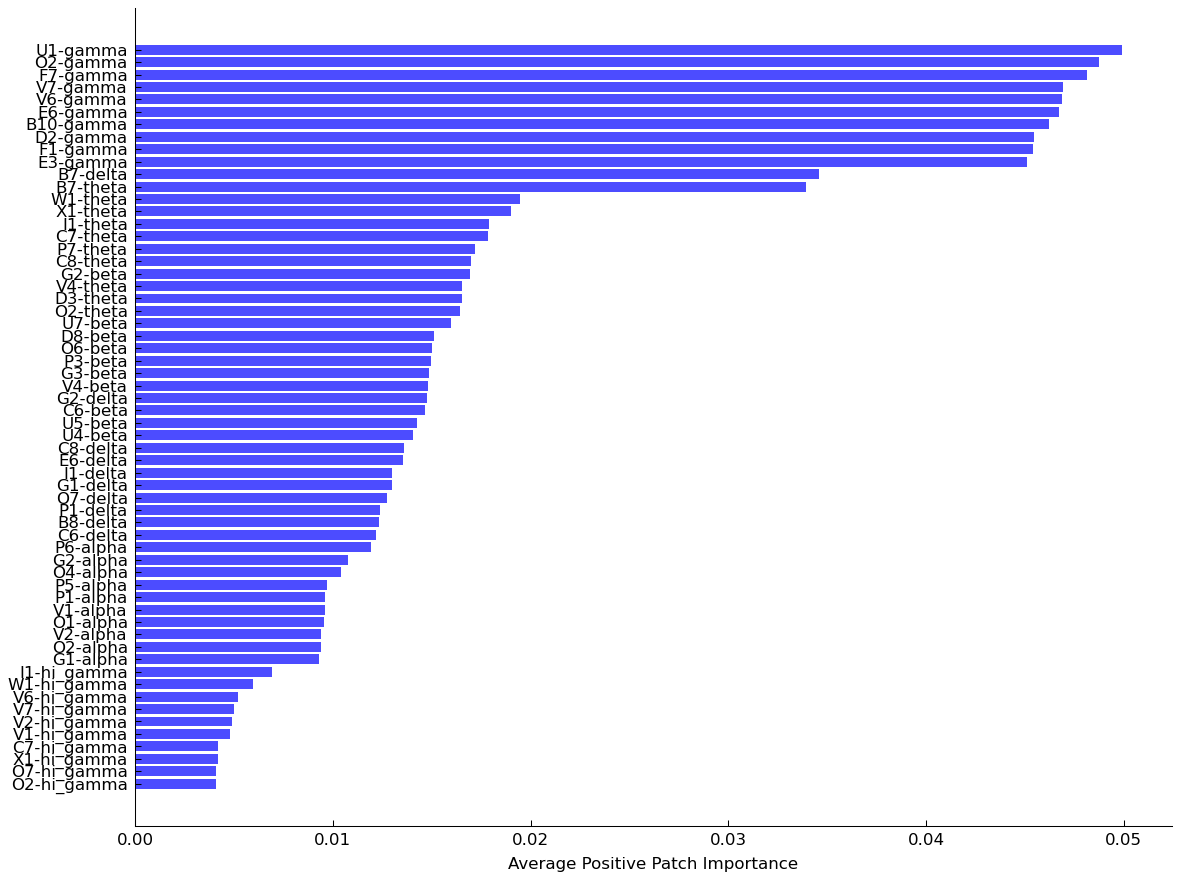

In [179]:
fig, ax = plt.subplots(dpi=150, figsize=(8, 6))
ax.barh(sorted_top_channels_w_anat["Channel Name"], sorted_top_channels_w_anat["Average Positive Patch Importance"], color="blue", alpha=0.7)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(axis='x', which='minor', bottom=False)
ax.tick_params(axis='y', which='minor', left=False)
ax.set_xlabel("Average Positive Patch Importance")
fig.tight_layout();

In [228]:
top_performers_time_domain = ["efri07", "efri13", "efri14", "efri18", "efri20"]
top_channels_df = {}
for subject in top_performers_time_domain:
    epochs = read_move_trial_epochs(bids_root, subject, resample_rate=None)
    top_channels_df[subject] = []
    for band in frequency_bands:
        band_imps = subject_scores_bands[subject][band]
        result = {
            "importances_mean": np.array(band_imps["validate_roc_auc_ovr_imp_mean"]),
            "importances": np.array(band_imps["validate_roc_auc_ovr_importances"]),
            "patch_inds": np.array(band_imps["validate_roc_auc_ovr_patch_inds"]),
            "usage_counts": np.array(band_imps["validate_roc_auc_ovr_usage_counts"])
        }

        imp_mean = np.array(result["importances_mean"])
        imp_mean[imp_mean <= 0] = 0.0
        imp_double_mean = np.mean(imp_mean, axis=1)
        order = np.argsort(imp_double_mean)
        top_chs = np.array(epochs.ch_names)[order[-10:]]
        top_imps = imp_double_mean[order[-10:]]
        top_channels_df[subject].extend(list(zip(top_chs, top_imps, np.repeat(subject, len(top_chs)), np.repeat(band, len(top_chs)))))

sers/ChesterHuynh/OneDrive - Johns Hopkins/research/motor-decoding/mtsmorf/io/move/read.py:94: RuntimeWarning: Cant add xy metrics to unsuccessful or perturbed trial.
  warn(f'Cant add xy metrics to unsuccessful or perturbed trial.')
/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/motor-decoding/mtsmorf/io/move/read.py:94: RuntimeWarning: Cant add xy metrics to unsuccessful or perturbed trial.
  warn(f'Cant add xy metrics to unsuccessful or perturbed trial.')
/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/motor-decoding/mtsmorf/io/move/read.py:94: RuntimeWarning: Cant add xy metrics to unsuccessful or perturbed trial.
  warn(f'Cant add xy metrics to unsuccessful or perturbed trial.')
/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/motor-decoding/mtsmorf/io/move/read.py:94: RuntimeWarning: Cant add xy metrics to unsuccessful or perturbed trial.
  warn(f'Cant add xy metrics to unsuccessful or perturbed trial.')
/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/moto

In [236]:
top_channels_all_subjects = pd.concat([pd.DataFrame(df) for df in top_channels_df.values()])
top_channels_all_subjects.columns = ["name", "Average Positive Patch Importance", "subject", "band"]
top_channels_all_subjects = top_channels_all_subjects.merge(sorted_channels, how="left", on=["subject", "name"])
top_channels_all_subjects.head()

name  Average Positive Patch Importance subject   band  \
0   C6                           0.012185  efri07  delta   
1   B8                           0.012312  efri07  delta   
2   P1                           0.012394  efri07  delta   
3   O7                           0.012729  efri07  delta   
4   G1                           0.012973  efri07  delta   

                                        anat  
0                 superior temporal sulcus R  
1                    middle temporal gyrus R  
2                                precuneus R  
3  inferior frontal gyrus (pars orbitalis) R  
4                            lingula gyrus R

In [242]:
shared_anat = top_channels_all_subjects.groupby("anat")["subject"].nunique()[top_channels_all_subjects.groupby("anat")["subject"].nunique() > 1].index
top_channels_all_subjects[top_channels_all_subjects.anat.isin(shared_anat)]

name  Average Positive Patch Importance subject      band  \
0     C6                           0.012185  efri07     delta   
1     B8                           0.012312  efri07     delta   
2     P1                           0.012394  efri07     delta   
6     E6                           0.013555  efri07     delta   
7     C8                           0.013600  efri07     delta   
..   ...                                ...     ...       ...   
290   E9                           0.018002  efri20  hi_gamma   
292  C11                           0.019051  efri20  hi_gamma   
293  X10                           0.019819  efri20  hi_gamma   
294   P7                           0.021709  efri20  hi_gamma   
296   F5                           0.021816  efri20  hi_gamma   

                                             anat  
0                      superior temporal sulcus R  
1                         middle temporal gyrus R  
2                                     precuneus R  
6                       inferior temporal gyrus R  
7                      superior temporal sulcus R  
..                                            ...  
290                     inferior temporal gyrus R  
292  superior temporal gyrus (planum temporale) R  
293                    superior temporal sulcus R  
294                        intraparietal sulcus R  
296                              fusiform gyrus R  

[194 rows x 5 columns]

In [252]:
group.subject.str.upper()

61     EFRI13
69     EFRI13
91     EFRI13
115    EFRI13
161    EFRI14
Name: subject, dtype: object

In [255]:
for anat, group in top_channels_all_subjects[top_channels_all_subjects.anat.isin(shared_anat)].groupby("anat"):
    print(*zip(list(group["subject"]), np.repeat(anat, len(group)), [f"{s}: {ch} ({b})" for s, ch, b in zip(group["subject"].str.upper().values, group["name"].values, group["band"].values)]), sep="\n")
    # print(group[["subject", "band", "name"]])

('efri13', 'angular gyrus L', "EFRI13: P'8 (alpha)")
('efri13', 'angular gyrus L', "EFRI13: P'6 (beta)")
('efri14', 'angular gyrus L', "EFRI14: Y'7 (alpha)")
('efri14', 'angular gyrus L', "EFRI14: Y'9 (hi_gamma)")
('efri07', 'angular gyrus R', 'EFRI07: P7 (theta)')
('efri07', 'angular gyrus R', 'EFRI07: D8 (beta)')
('efri13', 'angular gyrus R', 'EFRI13: P8 (delta)')
('efri13', 'angular gyrus R', 'EFRI13: P7 (theta)')
('efri13', 'angular gyrus R', 'EFRI13: P9 (theta)')
('efri13', 'angular gyrus R', 'EFRI13: P9 (beta)')
('efri20', 'angular gyrus R', 'EFRI20: P14 (delta)')
('efri20', 'angular gyrus R', 'EFRI20: P12 (alpha)')
('efri20', 'angular gyrus R', 'EFRI20: P12 (beta)')
('efri20', 'angular gyrus R', 'EFRI20: P12 (gamma)')
('efri07', 'cingulate cortex (posterior) R', 'EFRI07: X1 (theta)')
('efri07', 'cingulate cortex (posterior) R', 'EFRI07: D2 (gamma)')
('efri07', 'cingulate cortex (posterior) R', 'EFRI07: X1 (hi_gamma)')
('efri13', 'cingulate cortex (posterior) R', 'EFRI13: X2 (del

## Time Domain

In [5]:
subjects = metadata["subjects"]

subject_clf_scores = {}
for subject in subjects:
    path_identifiers = dict(subject=subject, session="efri", task="move", 
                            acquisition="seeg", run="01", suffix="ieeg", 
                            extension=".vhdr", root=bids_root)
    bids_path = BIDSPath(**path_identifiers)

    go_cue_durations = get_event_durations(
        bids_path, event_key="Left Target", periods=-1
    )
    left_target_durations = get_event_durations(
        bids_path, event_key="Left Target", periods=1
    )

    tmin = -max(go_cue_durations)
    tmax = max(left_target_durations)

    epochs, labels = get_event_data(bids_path, tmin=tmin - 0.2, tmax=tmax + 0.2)

    data = epochs.get_data()
    ntrials, nchs, nsteps = data.shape
    print(f"{subject.upper()}: data.shape = ({data.shape})")

    t = epochs.times
    mask = (t >= -np.asarray(go_cue_durations)[:, None, None]) & (
        t <= np.asarray(left_target_durations)[:, None, None]
    )
    masked_data = data * mask

    image_height = nchs
    image_width = nsteps

    clfs = initialize_classifiers(image_height, image_width, n_jobs=-1, random_state=rng)
    clf_scores = {}
    for clf in clfs:
        if isinstance(clf, rerfClassifier):
            clf_name = clf.get_params()["projection_matrix"]
        elif isinstance(clf, DummyClassifier):
            clf_name = clf.strategy
        else:
            clf_name = clf.__class__.__name__
        
        filename = results_path.parents[0] / "workstation_output" / subject / f"trial_specific_window/time_domain/{subject}_{clf_name}_results.json"
        with open(filename) as f:
            clf_scores[clf_name] = json.load(f)
    subject_clf_scores[subject] = clf_scores

Extracting parameters from /Users/ChesterHuynh/OneDrive - Johns Hopkins/efri/sub-efri02/ses-efri/ieeg/sub-efri02_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr...
Setting channel info structure...
Reading events from /Users/ChesterHuynh/OneDrive - Johns Hopkins/efri/sub-efri02/ses-efri/ieeg/sub-efri02_ses-efri_task-move_acq-seeg_run-01_events.tsv.
Reading channel info from /Users/ChesterHuynh/OneDrive - Johns Hopkins/efri/sub-efri02/ses-efri/ieeg/sub-efri02_ses-efri_task-move_acq-seeg_run-01_channels.tsv.
Reading 0 ... 9875999  =      0.000 ...  4937.999 secs...
/opt/anaconda3/envs/motor-decoding/lib/python3.8/site-packages/pandas/core/frame.py:3188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/opt/anaconda3/envs/motor-decodi

IndexError: index 133 is out of bounds for axis 0 with size 132

In [ ]:
df = pd.DataFrame(columns=["Classifier", "ROC AUC OvR", "Subject"])

for subject, clf_scores in subject_clf_scores.items():
    mtmorf_scores = clf_scores["MT-MORF"]
    srerf_scores = clf_scores["S-RerF"]
    dummy_scores = clf_scores["most_frequent"]

    rocs = {
        "MT-MORF": mtmorf_scores["test_roc_auc_ovr"],
        "S-ReRF": srerf_scores["test_roc_auc_ovr"],
        "Most Frequent": dummy_scores["test_roc_auc_ovr"]
    }
    roc_df = pd.DataFrame(rocs)
    roc_df = pd.melt(roc_df, value_vars=list(rocs.keys()), var_name="Classifier", value_name="ROC AUC OvR")
    roc_df["Subject"] = subject

    df = df.append(roc_df)

plt.rcParams.update({"font.size": 16})
fig, ax = plt.subplots(figsize=(18, 6), dpi=200)
pt.RainCloud(x="Subject", y="ROC AUC OvR", hue="Classifier", data=df, dodge=True, alpha=0.7, ax=ax)
ax.set_title("Cross-Validated Classifier Performance")
fig.tight_layout();

In [ ]:
df = pd.DataFrame(columns=["Classifier", "Accuracy", "Subject"])

for subject, clf_scores in subject_clf_scores.items():
    mtmorf_scores = clf_scores["MT-MORF"]
    srerf_scores = clf_scores["S-RerF"]
    rf_scores = clf_scores["RandomForestClassifier"]
    lr_scores = clf_scores["LogisticRegression"]
    dummy_scores = clf_scores["most_frequent"]

    rocs = {
        "MT-MORF": mtmorf_scores["test_accuracy"],
        "S-ReRF": srerf_scores["test_accuracy"],
        "RF": rf_scores["test_accuracy"],
        "Most Frequent": dummy_scores["test_accuracy"]
    }
    roc_df = pd.DataFrame(rocs)
    roc_df = pd.melt(roc_df, value_vars=list(rocs.keys()), var_name="Classifier", value_name="Accuracy")
    roc_df["Subject"] = subject

    df = df.append(roc_df)

plt.rcParams.update({"font.size": 16})
fig, ax = plt.subplots(figsize=(18, 6), dpi=200)
pt.RainCloud(x="Subject", y="Accuracy", hue="Classifier", data=df, dodge=True, alpha=0.7, ax=ax)
ax.set_title("Cross-Validated Classifier Performance")
fig.tight_layout();

## Freq Domain

In [24]:
nfreqs = 10
lfreq, hfreq = (70, 200)
freqs = np.logspace(*np.log10([lfreq, hfreq]), num=nfreqs)
n_cycles = freqs / 3.0

In [27]:
subjects = metadata["subjects"]

subject_clf_scores = {}
for subject in subjects:
    path_identifiers = dict(subject=subject, session="efri", task="move", 
                            acquisition="seeg", run="01", suffix="ieeg", 
                            extension=".vhdr", root=bids_root)
    bids_path = BIDSPath(**path_identifiers)

    go_cue_durations = get_event_durations(
        bids_path, event_key="Left Target", periods=-1
    )
    left_target_durations = get_event_durations(
        bids_path, event_key="Left Target", periods=1
    )

    tmin = -max(go_cue_durations)
    tmax = max(left_target_durations)

    epochs, labels = get_event_data(bids_path, tmin=tmin - 0.2, tmax=tmax + 0.2)

    power = tfr_morlet(
                epochs,
                freqs=freqs,
                n_cycles=n_cycles,
                average=False,
                return_itc=False,
                decim=3,
                n_jobs=-1,
    )
    power.crop(tmin=tmin, tmax=tmax)
    data = power.data
    ntrials, nchs, nfreqs, nsteps = data.shape
    print(f"{subject.upper()}: data.shape = ({data.shape})")

    t = power.times
    mask = (t >= -np.asarray(go_cue_durations)[:, None, None, None]) & (
        t <= np.asarray(left_target_durations)[:, None, None, None]
    )
    masked_data = data * mask

    image_height = nchs * nfreqs
    image_width = nsteps

    clfs = initialize_classifiers(image_height, image_width, n_jobs=-1, random_state=rng)
    clf_scores = {}
    for clf in clfs:
        if isinstance(clf, rerfClassifier):
            clf_name = clf.get_params()["projection_matrix"]
        elif isinstance(clf, DummyClassifier):
            clf_name = clf.strategy
        else:
            clf_name = clf.__class__.__name__
        
        filename = results_path / subject / f"trial_specific_window/freq_domain/{subject}_{clf_name}_results.json"
        with open(filename) as f:
            clf_scores[clf_name] = json.load(f)
    subject_clf_scores[subject] = clf_scores

, 'Hit Target', 'Leave Target', 'Left Target', 'Reserved (End Trial)', 'Reserved (Start Trial)', 'Reward', 'Show Center', 'Speed Fail', 'Speed Feedback', 'Speed Instruction']
Not setting metadata
Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Loading data for 132 events and 8024 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 1 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 999.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 999.50 Hz)
- Filter length: 6601 samples (3.300 sec)

Dropped 27 epochs: 0, 8, 9, 17, 21, 24, 35, 42, 48, 51, 52, 55, 60, 62, 71, 78, 79, 93, 9

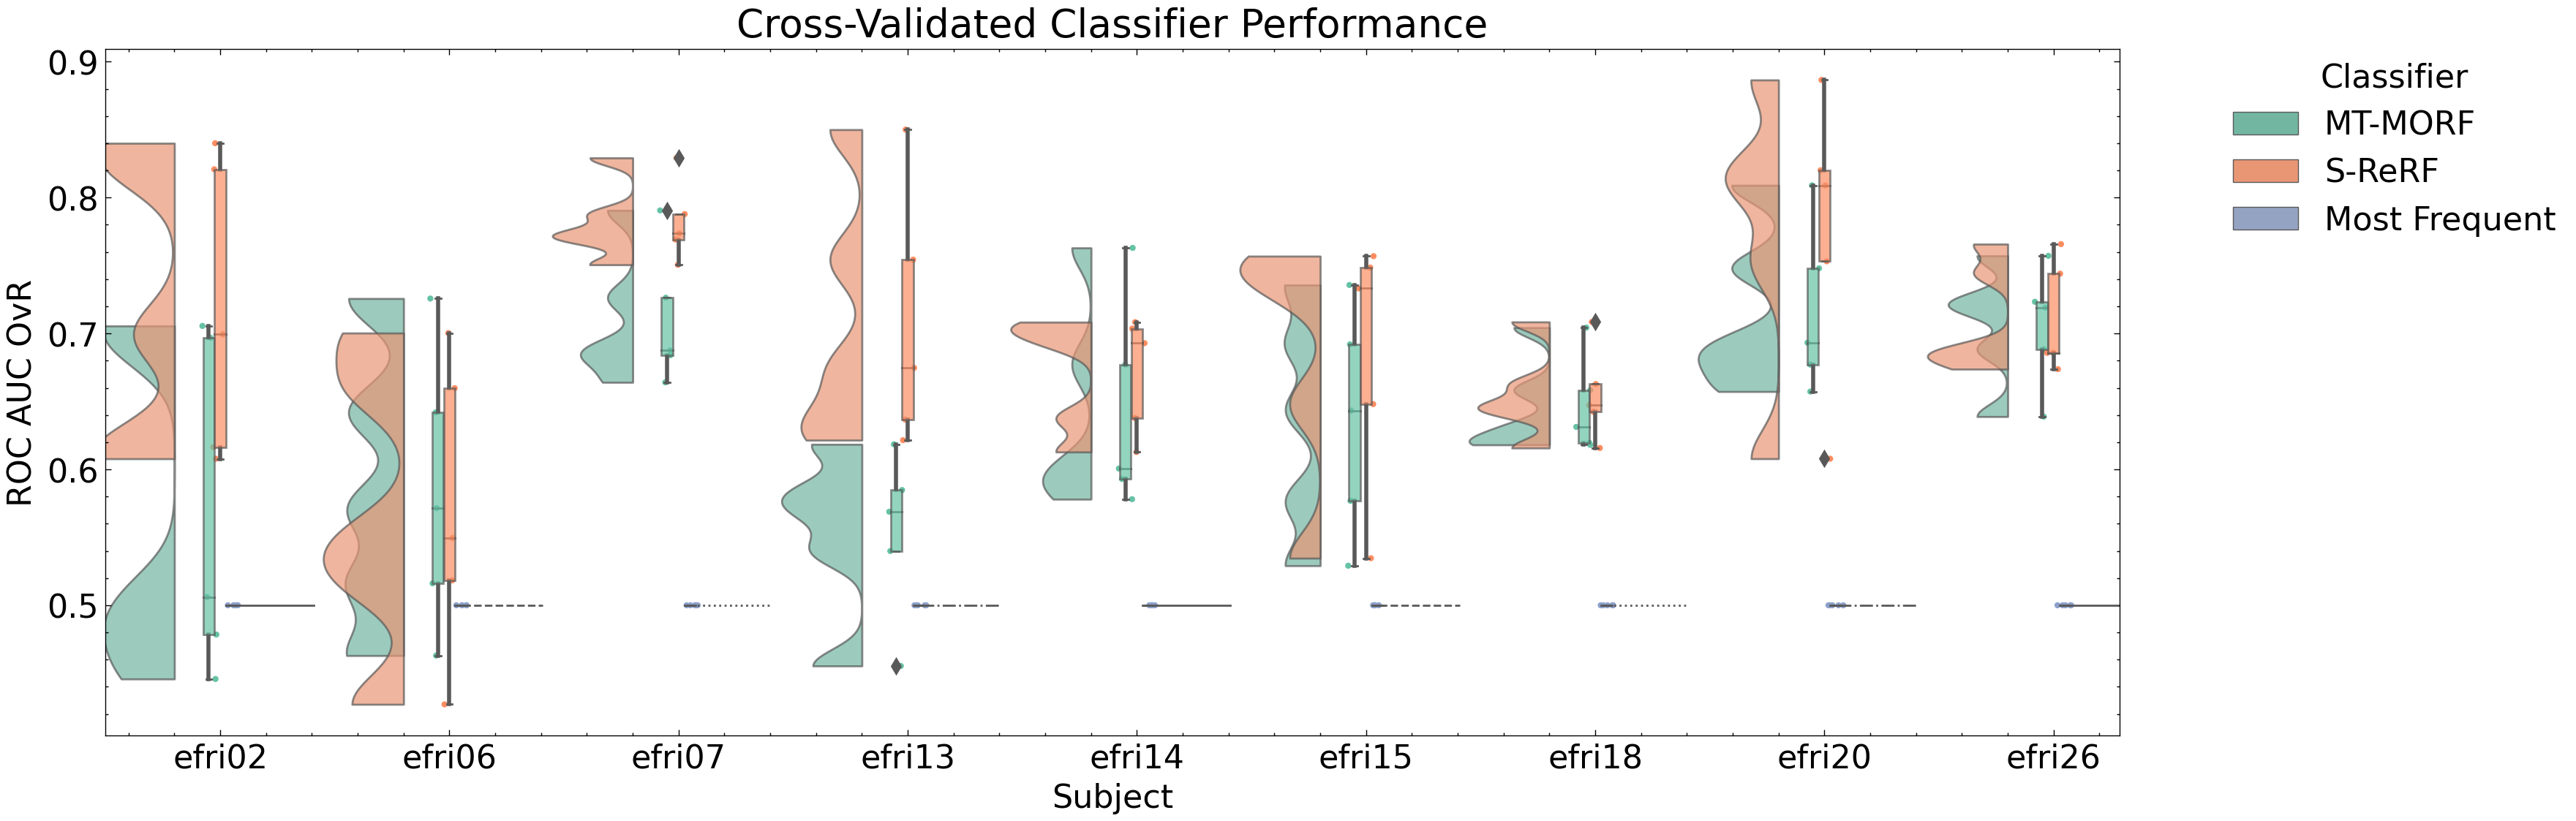

In [28]:
df = pd.DataFrame(columns=["Classifier", "ROC AUC OvR", "Subject"])

for subject, clf_scores in subject_clf_scores.items():
    mtmorf_scores = clf_scores["MT-MORF"]
    srerf_scores = clf_scores["S-RerF"]
    dummy_scores = clf_scores["most_frequent"]

    rocs = {
        "MT-MORF": mtmorf_scores["test_roc_auc_ovr"],
        "S-ReRF": srerf_scores["test_roc_auc_ovr"],
        "Most Frequent": dummy_scores["test_roc_auc_ovr"]
    }
    roc_df = pd.DataFrame(rocs)
    roc_df = pd.melt(roc_df, value_vars=list(rocs.keys()), var_name="Classifier", value_name="ROC AUC OvR")
    roc_df["Subject"] = subject

    df = df.append(roc_df)

plt.rcParams.update({"font.size": 16})
fig, ax = plt.subplots(figsize=(18, 6), dpi=200)
pt.RainCloud(x="Subject", y="ROC AUC OvR", hue="Classifier", data=df, dodge=True, alpha=0.7, ax=ax)
ax.set_title("Cross-Validated Classifier Performance")
fig.tight_layout();

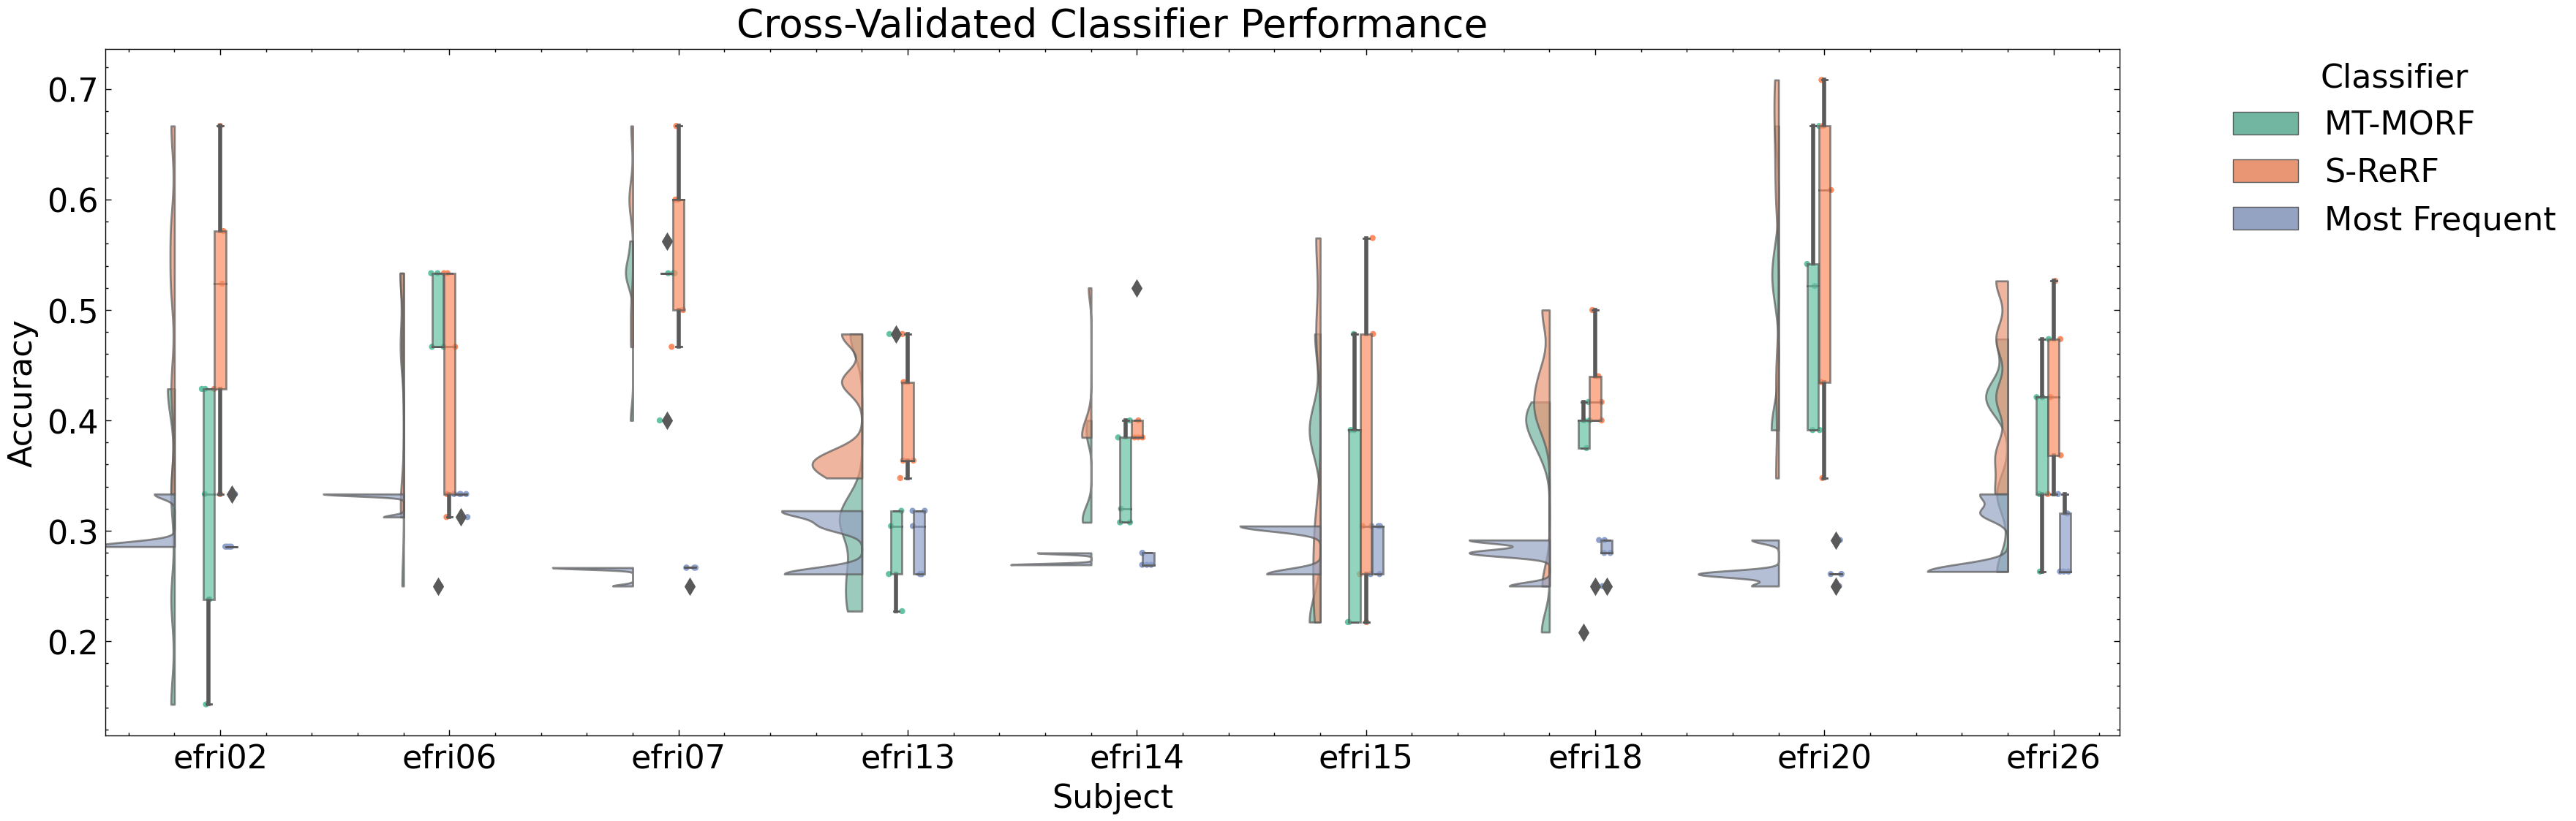

In [29]:
df = pd.DataFrame(columns=["Classifier", "Accuracy", "Subject"])

for subject, clf_scores in subject_clf_scores.items():
    mtmorf_scores = clf_scores["MT-MORF"]
    srerf_scores = clf_scores["S-RerF"]
    dummy_scores = clf_scores["most_frequent"]

    rocs = {
        "MT-MORF": mtmorf_scores["test_accuracy"],
        "S-ReRF": srerf_scores["test_accuracy"],
        "Most Frequent": dummy_scores["test_accuracy"]
    }
    roc_df = pd.DataFrame(rocs)
    roc_df = pd.melt(roc_df, value_vars=list(rocs.keys()), var_name="Classifier", value_name="Accuracy")
    roc_df["Subject"] = subject

    df = df.append(roc_df)

plt.rcParams.update({"font.size": 16})
fig, ax = plt.subplots(figsize=(18, 6), dpi=200)
pt.RainCloud(x="Subject", y="Accuracy", hue="Classifier", data=df, dodge=True, alpha=0.7, ax=ax)
ax.set_title("Cross-Validated Classifier Performance")
fig.tight_layout();